### Statistical and Grid network package

In [21]:
import os
import numpy as np
import networkx as nx
import pandas as pd
import copy

#Pandapower Package
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
import pandapower.diagnostic as diagnostic

from pandapower.powerflow import LoadflowNotConverged
from pandapower.diagnostic import diagnostic
from pandapower.control import ConstControl
from pandapower.timeseries import DFData, OutputWriter, run_timeseries
from pandapower.pypower.makeYbus import makeYbus

import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.linalg
import scipy.sparse as sp
from tqdm import tqdm

### Causal Inference Package

In [22]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import fisherz
from sklearn.preprocessing import StandardScaler
from scipy.special import psi

from dowhy import CausalModel
from dowhy import gcm 

In [23]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

### Define the Function to Check  network whether meet thte N-1 contingency criterion

In [24]:
# Define function to check whether the network meet the N-1 contingency criterion
def check_n_1_contingency(net):
    critical_elements = []
    
    # Backup original network
    original_net = copy.deepcopy(net)
    
    # Test line outages
    for line in net.line.index:
        net_copy = copy.deepcopy(original_net)
        net_copy.line.at[line, "in_service"] = False  # Remove one line
        try:
            pp.runpp(net_copy, algorithm="nr")
        except pp.powerflow.LoadflowNotConverged:
            critical_elements.append(f"Line {line} outage causes failure.")
            continue
        
        # Check for overloads
        if any(net_copy.res_line.loading_percent > 100):
            critical_elements.append(f"Line {line} outage causes overloads.")

    # Test generator outages
    for gen in net.gen.index:
        net_copy = copy.deepcopy(original_net)
        net_copy.gen.at[gen, "in_service"] = False  # Remove one generator
        try:
            pp.runpp(net_copy, algorithm="nr")
        except pp.powerflow.LoadflowNotConverged:
            critical_elements.append(f"Generator {gen} outage causes failure.")
            continue

        # Check for voltage violations rule
        if any((net_copy.res_bus.vm_pu < 0.95) | (net_copy.res_bus.vm_pu > 1.05)):
            critical_elements.append(f"Generator {gen} outage causes voltage issues.")

    return critical_elements

### Load the Network Testcase

In [25]:
# Load the 30-bus system
net = pn.case30()

### Built the Function to Reinforce the Network to meet the N-1 Criterion

In [26]:
# Function to Reinforce the network based on contingency violations
def reinforce_network(net):
    original_net = copy.deepcopy(net)
    overloaded_lines = []
    problematic_gens = []
   
    for line in net.line.index:
        net_copy = copy.deepcopy(original_net)
        net_copy.line.at[line, "in_service"] = False  # Simulate line outage
        try:
            pp.runpp(net_copy)
        except pp.powerflow.LoadflowNotConverged:
            overloaded_lines.append(line)
            continue
        if any(net_copy.res_line.loading_percent > 100):
            overloaded_lines.append(line)
    
    # Add parallel lines to overloaded lines
    for line in overloaded_lines:
        from_bus = net.line.loc[line, "from_bus"]
        to_bus = net.line.loc[line, "to_bus"]
        print(f"Adding parallel line between Bus {from_bus} and Bus {to_bus} to mitigate overload.")
        pp.create_line_from_parameters(net, from_bus=from_bus, to_bus=to_bus, 
                                       length_km=1.0, r_ohm_per_km=0.05, 
                                       x_ohm_per_km=0.1, c_nf_per_km=0, 
                                       max_i_ka=1.5)  # Higher capacity
    
    # Identify problematic generators
    problematic_gens = []
    for gen in net.gen.index:
        net_copy = copy.deepcopy(original_net)
        net_copy.gen.at[gen, "in_service"] = False  # Simulate generator outage
        try:
            pp.runpp(net_copy)
        except pp.powerflow.LoadflowNotConverged:
            problematic_gens.append(gen)
            continue
        if any((net_copy.res_bus.vm_pu < 0.95) | (net_copy.res_bus.vm_pu > 1.05)):
            problematic_gens.append(gen)

    # Increase generator capacities to provide redundancy
    for gen in problematic_gens:
        net.gen.at[gen, "p_mw"] *= 1.2  # Increase power generation by 20%
        print(f"Increasing capacity of Generator {gen} to improve voltage stability.")

    return net

# Reinforce the network
net = reinforce_network(net)

# Run contingency check again
pp.runpp(net)
print("Reinforced system power flow successful.")

# Check if violations still exist
violations = check_n_1_contingency(net)
if violations:
    print("grid netwrok still has issues under N-1 contingency.")
    for v in violations:
        print(v)
else:
    print("The grid netwrok satisfies the N-1 contingency criterion!")

Adding parallel line between Bus 0 and Bus 1 to mitigate overload.
Adding parallel line between Bus 0 and Bus 2 to mitigate overload.
Adding parallel line between Bus 1 and Bus 3 to mitigate overload.
Adding parallel line between Bus 2 and Bus 3 to mitigate overload.
Adding parallel line between Bus 1 and Bus 4 to mitigate overload.
Adding parallel line between Bus 1 and Bus 5 to mitigate overload.
Adding parallel line between Bus 3 and Bus 5 to mitigate overload.
Adding parallel line between Bus 4 and Bus 6 to mitigate overload.
Adding parallel line between Bus 5 and Bus 6 to mitigate overload.
Adding parallel line between Bus 5 and Bus 7 to mitigate overload.
Adding parallel line between Bus 5 and Bus 8 to mitigate overload.
Adding parallel line between Bus 5 and Bus 9 to mitigate overload.
Adding parallel line between Bus 8 and Bus 10 to mitigate overload.
Adding parallel line between Bus 8 and Bus 9 to mitigate overload.
Adding parallel line between Bus 3 and Bus 11 to mitigate ove

##  Show Network Basic Information

### The PV bus (which contains the conventional generators) information

In [27]:
# View all generator (gen) bus information and Slack bus
gen_info = net.gen
print(gen_info)
print(net.ext_grid)

# Print the bus number where the generator is located
pv_bus_numbers = net.gen['bus'].values
print("Generator (PV) bus numbers:", pv_bus_numbers)

# Identify the 5 PV buses in the 30-bus system
pv_buses = [1, 21, 26, 22, 12]

   name  bus    p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1  73.164    1.0     NaN       -20.0        60.0      1.0  False   
1  None   21  25.908    1.0     NaN       -15.0        62.5      1.0  False   
2  None   26  32.292    1.0     NaN       -15.0        48.7      1.0  False   
3  None   22  19.200    1.0     NaN       -10.0        40.0      1.0  False   
4  None   12  37.000    1.0     NaN       -15.0        44.7      1.0  False   

   in_service  slack_weight  type  controllable  max_p_mw  min_p_mw  
0        True           0.0  None          True      80.0       0.0  
1        True           0.0  None          True      50.0       0.0  
2        True           0.0  None          True      55.0       0.0  
3        True           0.0  None          True      30.0       0.0  
4        True           0.0  None          True      40.0       0.0  
   name  bus  vm_pu  va_degree  slack_weight  in_service  max_p_mw  min_p_mw  \
0  None    0    1.0      

### The load bus information

In [28]:
# View the bus information of the external power grid (Slack bus)
slack_bus_numbers = net.ext_grid['bus'].values
print("Slack bus numbers:", slack_bus_numbers)

# View load information
print(net.load)

# Calculate total active power and reactive power
total_p = net.load['p_mw'].sum()  # Total active power
total_q = net.load['q_mvar'].sum()  # Total reactive power

print(f"Total active power load of 30-bus system: {total_p} MW")
print(f"Total reactive power load of 30-bus system: {total_q} MVar")

Slack bus numbers: [0]
    name  bus  p_mw  q_mvar  const_z_percent  const_i_percent  sn_mva  \
0   None    1  21.7    12.7              0.0              0.0     NaN   
1   None    2   2.4     1.2              0.0              0.0     NaN   
2   None    3   7.6     1.6              0.0              0.0     NaN   
3   None    6  22.8    10.9              0.0              0.0     NaN   
4   None    7  30.0    30.0              0.0              0.0     NaN   
5   None    9   5.8     2.0              0.0              0.0     NaN   
6   None   11  11.2     7.5              0.0              0.0     NaN   
7   None   13   6.2     1.6              0.0              0.0     NaN   
8   None   14   8.2     2.5              0.0              0.0     NaN   
9   None   15   3.5     1.8              0.0              0.0     NaN   
10  None   16   9.0     5.8              0.0              0.0     NaN   
11  None   17   3.2     0.9              0.0              0.0     NaN   
12  None   18   9.5     3.4 

### The Capacity of the Conventional Generators Information

In [29]:
# Initialize an empty list to store installed capacities of each generator
installed_capacities = []

# Loop through each row in the gen_info DataFrame to extract information
for i, row in gen_info.iterrows():
    bus_id = row['bus']  # Get the bus ID for the generator
    installed_capacity = row['max_p_mw']  # Get the installed capacity of the generator in MW
    print(f"Conventional Generator at Bus {bus_id}: Installed Capacity = {installed_capacity} MW")
    installed_capacities.append(installed_capacity)  # Append the capacity to the list

# Calculate the total installed capacity of all generators
total_installed_capacity = sum(installed_capacities)
print(f"Total Installed Capacity = {total_installed_capacity} MW")

Conventional Generator at Bus 1: Installed Capacity = 80.0 MW
Conventional Generator at Bus 21: Installed Capacity = 50.0 MW
Conventional Generator at Bus 26: Installed Capacity = 55.0 MW
Conventional Generator at Bus 22: Installed Capacity = 30.0 MW
Conventional Generator at Bus 12: Installed Capacity = 40.0 MW
Total Installed Capacity = 255.0 MW


### Deactivate Some Conventional Generators to introduce Solar-Based generation with static generator (Same Magnitude capacity)
Replace a deactivated 45 MW conventional generator with a solar-based, variable power source connected to a static generator (sgen) at a bus
Penetration Level (%)=Installed PV Capacity/Total Installed Generation Capacity×100


Case1:  Replace the deactivated  conventional generator with a solar-based, variable power source connected to a static generator (sgen) at a bus

Case 2: Do not drop out of the conventional generators, just decrease their capacity, and add the static generators 

Case3: By incorporating sudden events—such
as spike scenarios to mimic rapid irradiance changes due to cloud movement—and time-varying conditions. 
extended with case1

Case4: By incorporating sudden events—such
as spike scenarios to mimic rapid irradiance changes due to cloud movement—and time-varying conditions. 
extended with case2

In [30]:
# Deactive specific generators(bus 21 22) # Make the solar-based generators more significant 

# Drop Around 45 MW Acive Power with the conventional generators / with 80mw capacity 
# Around 30% pecent penetration level
net.gen.drop(net.gen[net.gen['bus'].isin([21,22])].index, inplace=True)

# Verify the remaining generators
print(net.gen)

   name  bus    p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1  73.164    1.0     NaN       -20.0        60.0      1.0  False   
2  None   26  32.292    1.0     NaN       -15.0        48.7      1.0  False   
4  None   12  37.000    1.0     NaN       -15.0        44.7      1.0  False   

   in_service  slack_weight  type  controllable  max_p_mw  min_p_mw  
0        True           0.0  None          True      80.0       0.0  
2        True           0.0  None          True      55.0       0.0  
4        True           0.0  None          True      40.0       0.0  


In [31]:
print(net.sgen)

Empty DataFrame
Columns: [name, bus, p_mw, q_mvar, sn_mva, scaling, in_service, type, current_source]
Index: []


## Load ERCOT Data and Data Processing

In [32]:
# Load the CSV file with the ERCOT time-series data file
#file_path = 'C:\\Users\\default.DESKTOP-C4C7JDR\\Desktop\\ERCOT SOLAR DATA.xlsx'  # Home PC
file_path = 'C:\\Users\\jliu359\\OneDrive - Syracuse University\\Desktop\\ERCOT SOLAR DATA.xlsx' #Lab PC
ercot_data = pd.read_excel(file_path)
#  Read data
print(ercot_data.head())

# Extract the time and PV generation columns
# Set the time column as the index and ensure it's in datetime format
ercot_data['Time (Hour-Ending)'] = pd.to_datetime(ercot_data['Time (Hour-Ending)'])
ercot_data.set_index('Time (Hour-Ending)', inplace=True)
pv_generation = ercot_data['ERCOT.PVGR.GEN']

#Scale ERCOT solar generation to match the total installed capacity of the added genenator's capacity in the 30-bus system
# 14249 MW is the total solar installed capacity in the ERCOT dataset
# Scaling_factor = total_installed_capacity / 14249 
# Calculate the mean and standard deviation of the PV generation
mean_pv_ercot = pv_generation.mean()
std_pv_ercot= pv_generation.std()

print(f"Mean of PV generation: {mean_pv_ercot:.4f} MW")
print(f"Standard deviation of PV generation: {std_pv_ercot:.4f} MW")

# Prepare a DataFrame to hold profiles for each PV bus with an integer index
profiles_df = pd.DataFrame(index=range(len(ercot_data)))

   Time (Hour-Ending)       Date    ERCOT.LOAD  ERCOT.PVGR.GEN  \
0 2023-01-01 01:00:00 2023-01-01  35829.306163        0.449746   
1 2023-01-01 02:00:00 2023-01-01  35245.390234        0.454733   
2 2023-01-01 03:00:00 2023-01-01  34599.761810        0.443528   
3 2023-01-01 04:00:00 2023-01-01  34227.151061        0.458567   
4 2023-01-01 05:00:00 2023-01-01  34093.414143        0.451126   

   Total Solar Installed, MW  Solar Output, % of Load  \
0                      14249                 0.001255   
1                      14249                 0.001290   
2                      14249                 0.001282   
3                      14249                 0.001340   
4                      14249                 0.001323   

   Solar Output, % of Installed  Solar 1-hr MW change  Solar 1-hr % change  \
0                      0.003156                   NaN                  NaN   
1                      0.003191                   0.0                  0.0   
2                      0.0

### Add the Static generators (Solar-Generation) and build the constant power factor control mode with reactive power on sgen

In [33]:
# Define Parameters
total_drop_conventional_capacity= 80  # MW capacity for deactiving the conventional generators
n = 8  # Number of added static（solar) generators as solar injection (Set this number between 5 and 10)

# Select buses (load buses) to add the solar generation injection with the static generators
solar_sgen_buses= [1, 6, 7, 11, 14, 16, 20, 29]  # Buses with the solar-based generator with the load bus

assert len(solar_sgen_buses) == n, "Number of buses must match number of generators."
# Distribute total PV capacity equally per static generator
solar_installed_capacities_per_sgen = np.full(n, total_drop_conventional_capacity / n)

# Constant power factor 
power_factor = 0.95
q_mvar_per_sgen = solar_installed_capacities_per_sgen * np.tan(np.arccos(power_factor))

# Add static generators
for i, bus in enumerate(solar_sgen_buses):
    pp.create_sgen(net, 
                   bus=bus, 
                   p_mw=0, 
                   q_mvar=q_mvar_per_sgen[i], 
                   max_p_mw=solar_installed_capacities_per_sgen[i], 
                   name=f"Solar_StaticGen_{bus}", 
                   type="solar")

print(f"Added {n} solar-based static generators with {total_drop_conventional_capacity / n:.2f} MW Capcacity each.")
print(net.sgen)

Added 8 solar-based static generators with 10.00 MW Capcacity each.
                 name  bus  p_mw    q_mvar  sn_mva  scaling  in_service  \
0   Solar_StaticGen_1    1   0.0  3.286841     NaN      1.0        True   
1   Solar_StaticGen_6    6   0.0  3.286841     NaN      1.0        True   
2   Solar_StaticGen_7    7   0.0  3.286841     NaN      1.0        True   
3  Solar_StaticGen_11   11   0.0  3.286841     NaN      1.0        True   
4  Solar_StaticGen_14   14   0.0  3.286841     NaN      1.0        True   
5  Solar_StaticGen_16   16   0.0  3.286841     NaN      1.0        True   
6  Solar_StaticGen_20   20   0.0  3.286841     NaN      1.0        True   
7  Solar_StaticGen_29   29   0.0  3.286841     NaN      1.0        True   

    type  current_source  max_p_mw  
0  solar            True      10.0  
1  solar            True      10.0  
2  solar            True      10.0  
3  solar            True      10.0  
4  solar            True      10.0  
5  solar            True      10.0

In [34]:
# Calculate base mean and std for each static generator
total_ercot_pv_capacity=14249 # total capacity of ercot
scaling_factor = total_drop_conventional_capacity/ (n*total_ercot_pv_capacity)
solar_mean_per_sgen = mean_pv_ercot* scaling_factor
solar_std_per_sgen = mean_pv_ercot * scaling_factor
# Print result
print(f"Scaling factor: {scaling_factor:.6f}")
print(f"Solar mean generation per static generator: {solar_mean_per_sgen:.4f} MW")
print(f"Solar std deviation per static generator: {solar_std_per_sgen:.4f} MW")
solar_mean_per_sgen = solar_mean_per_sgen * np.ones(n)
solar_std_per_sgen =  solar_mean_per_sgen* np.ones(n)

Scaling factor: 0.000702
Solar mean generation per static generator: 2.5531 MW
Solar std deviation per static generator: 2.5531 MW


### The function based on the Z-matrix (Impedance matrix) to Compute the Electrical Distances (Generators and Loads) 
This function computes the admittance matrix (Ybus) in per unit (p.u.).
The per-unit admittance is derived from the network base values

In [35]:
# Function to compute distances from Z-matrix
def compute_distances(bus_indices_1, bus_indices_2, Z_matrix):
    distances = []
    for i in bus_indices_1:
        for j in bus_indices_2:
            if i != j:  # Avoid self-distances
                impedance_distance = abs(Z_matrix[i, j])  # Take absolute impedance value
                distances.append((i, j, impedance_distance))
    return distances

### Identify Bus Indices for Conventional and solar Generator and Load Buses

In [36]:
conventional_gen_buses = net.gen['bus'].tolist()  # Conventional generators
solar_sgen_buses = net.sgen['bus'].tolist()  # Solar PV buses
load_buses = net.load['bus'].tolist()  # Load buses
# Print the lists
print("Conventional Generator Buses:", conventional_gen_buses)
print("Solar Generator Buses:", solar_sgen_buses)
print("Load Buses:", load_buses)
# print("Generator Buses:", gen_buses)

Conventional Generator Buses: [1, 26, 12]
Solar Generator Buses: [1, 6, 7, 11, 14, 16, 20, 29]
Load Buses: [1, 2, 3, 6, 7, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 28, 29]


### Select Sensitive components for the added N-2 contingnecy events

In [37]:
### load the sensitive components for the n-2 contingency events pick
df_sensitive_loaded = pd.read_csv("sensitive_components_case3.csv")

# Convert back to list of tuples
sensitive_components= list(df_sensitive_loaded.itertuples(index=False, name=None))
print(sensitive_components)

[('line', 34), ('line', 37), ('line', 40), ('line', 46), ('line', 43), ('line', 49), ('line', 52), ('line', 58), ('line', 55), ('line', 6), ('sgen', 2), ('line', 3), ('line', 9), ('line', 15), ('line', 67), ('line', 18), ('line', 76), ('line', 27), ('line', 24), ('line', 36), ('line', 42), ('line', 51), ('line', 54), ('line', 57), ('line', 2), ('line', 8), ('line', 66), ('line', 5), ('line', 11), ('line', 75), ('line', 14), ('line', 78), ('line', 17), ('gen', 2), ('line', 81), ('line', 26), ('line', 35), ('line', 44), ('line', 41), ('line', 47), ('line', 50), ('line', 56), ('line', 59), ('line', 65), ('sgen', 6), ('line', 68), ('line', 13), ('sgen', 3), ('line', 10), ('line', 16), ('line', 77), ('line', 25)]


In [38]:
# Separate line and generator entries
line_ids = [idx for typ, idx in sensitive_components if typ == "line"]
gen_ids = [idx for typ, idx in sensitive_components if typ == "gen"]
sgen_ids = [idx for typ, idx in sensitive_components if typ == "sgen"]

# Create dataframes with selected rows
df_sensitive_lines = net.line.loc[line_ids].copy()
df_sensitive_gens = net.gen.loc[gen_ids].copy()
df_sensitive_sgens = net.sgen.loc[sgen_ids].copy()

# Add index as a column for clarity
df_sensitive_lines["line_id"] = df_sensitive_lines.index
df_sensitive_gens["gen_id"] = df_sensitive_gens.index
df_sensitive_sgens["sgen_id"] = df_sensitive_sgens.index

# Rearrange columns to show ID first
df_sensitive_lines = df_sensitive_lines[["line_id"] + [col for col in df_sensitive_lines.columns if col != "line_id"]]
df_sensitive_gens = df_sensitive_gens[["gen_id"] + [col for col in df_sensitive_gens.columns if col != "gen_id"]]
df_sensitive_sgens = df_sensitive_sgens[["sgen_id"] + [col for col in df_sensitive_sgens.columns if col != "sgen_id"]]

# Show
print("Sensitive Lines:")
display(df_sensitive_lines)

print("Sensitive Conventional Generators:")
display(df_sensitive_gens)

print("Sensitive Solar Generators:")
display(df_sensitive_sgens)

Sensitive Lines:


,line_id,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service,max_loading_percent,geo
34,34,None,None,24,26,1.0,20.0475,38.2725,0.000000,0.0,0.068427,1.0,1,ol,True,100.0,NaN
37,37,None,None,26,29,1.0,58.3200,109.3500,0.000000,0.0,0.068427,1.0,1,ol,True,100.0,NaN
40,40,None,None,5,27,1.0,3.6450,10.9350,145.546359,0.0,0.136853,1.0,1,ol,True,100.0,NaN
46,46,None,None,1,5,1.0,0.0500,0.1000,0.000000,0.0,1.500000,1.0,1,None,True,NaN,NaN
43,43,None,None,1,3,1.0,0.0500,0.1000,0.000000,0.0,1.500000,1.0,1,None,True,NaN,NaN
49,49,None,None,5,6,1.0,0.0500,0.1000,0.000000,0.0,1.500000,1.0,1,None,True,NaN,NaN
52,52,None,None,5,9,1.0,0.0500,0.1000,0.000000,0.0,1.500000,1.0,1,None,True,NaN,NaN
58,58,None,None,11,14,1.0,0.0500,0.1000,0.000000,0.0,1.500000,1.0,1,None,True,NaN,NaN
55,55,None,None,3,11,1.0,0.0500,0.1000,0.000000,0.0,1.500000,1.0,1,None,True,NaN,NaN
6,6,None,None,3,5,1.0,1.8225,7.2900,0.000000,0.0,0.384900,1.0,1,ol,True,100.0,NaN


Sensitive Conventional Generators:


,gen_id,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,controllable,max_p_mw,min_p_mw
2,2,None,26,32.292,1.0,NaN,-15.0,48.7,1.0,False,True,0.0,None,True,55.0,0.0


Sensitive Solar Generators:


,sgen_id,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source,max_p_mw
2,2,Solar_StaticGen_7,7,0.0,3.286841,NaN,1.0,True,solar,True,10.0
6,6,Solar_StaticGen_20,20,0.0,3.286841,NaN,1.0,True,solar,True,10.0
3,3,Solar_StaticGen_11,11,0.0,3.286841,NaN,1.0,True,solar,True,10.0


### Define the Number of Scenarios and Monte Carlo runs- add Sudden Events – Spikes (Cloud Movement)
### Define the test case system factor's variation range

In [39]:
n_scenarios = 10000 # Number of scenarios
n_runs_per_scenario = 100 # Monte Carlo runs per scenario quarter resolution
scenario_results = []

# Define the variation range with the original mean and standard deviation values of the static generators' output of the PV buses
mean_variation = 1  # ±100% variation in solar generation mean
std_variation = 0.5  # ±50% variation in solar generation std dev

# Define variation range for line distances by introducing different distances between the variables
line_length_variation = 0.1  # ±10% variation in line impedance lengths

spike_probability = 0.05  # 5% chance of a sudden irradiance drop or spike
spike_magnitude_range = (0.3, 0.6)  # 30% to 60% random drop with the injection magnitude when the events happen

contingency1_rate = 0.4   #Introduce N-1 contingency events in 40% of the total generated scenarios
contingency2_rate = 0.2   #Introduce N-2 contingency events in 20% of the total generated scenarios
np.random.seed(42)  # Ensure reproducibility

base_net = copy.deepcopy(net)  # Restore base network to avoid compounding changes

# Create a synthetic diurnal irradiance profile (simulates time-of-day variation in solar output)
# Avoiding convergence issues at near-zero injection .
# The profile  varies between 0.5 and 1.0.
diurnal_profile = 0.5+0.5*np.sin(np.linspace(0, np.pi, n_runs_per_scenario))  # Rises and falls like a day 

# Create output folder for all failure diagnostics ---
output_dir = "loadflow_failures"
os.makedirs(output_dir, exist_ok=True)

### Run Different scenarios using the different mean and standard deviation of static generator(solar injection) outputs, Along with varying grid network topologies, also add the contingency events(N-1 and N-2) and Record the factor

In [ ]:
spike_event_count_per_scenario = {} #Defining a record container with record the number of spike events 

for scenario in range(n_scenarios):
    print(f"Running Scenario {scenario + 1}/{n_scenarios}")
    scenario_lolps = []  # Store LOLP results for the scenario
    
    spike_event_count_per_scenario[scenario] = 0 # Initialize the counter for the current scenario
   
    # Assign the randomize PV generation parameters (mean and std) for each scenario
    scenario_means = [
        max(1e-6, 3 * solar_mean_per_sgen[i] * (1 + np.random.uniform(-mean_variation, mean_variation)))
        for i in range(n)
    ]
    scenario_stds = [
        max(1e-6, solar_std_per_sgen[i] * (1 + np.random.uniform(-std_variation, std_variation)))
        for i in range(n)
    ]

    # Initialize storage for per-bus PV outputs and system metrics dicts per scenario

    bus_vm = {bus: [] for bus in net.bus.index}
    bus_angle = {bus: [] for bus in net.bus.index}
    sgen_output_per_bus = {bus: [] for bus in solar_sgen_buses}
    gen_output_per_bus = {bus: [] for bus in conventional_gen_buses}
    
    total_solar_generation = []
    total_generation = []
    total_con_generation=[]
    total_reactive_power = []
    voltage_deviations = []
    
    # Restore the base network to avoid compounding changes
    net = copy.deepcopy(base_net)

    # Add N-1 and N-2 Contingency events to the scenarios
    contingency_applied = False
    failed_components = []
    
    contingency_roll = np.random.rand()
    
    if contingency_roll < contingency2_rate:
        selected_pair = np.random.choice(len(sensitive_components), 2, replace=False)
        for i in selected_pair:
            typ, idx = sensitive_components[i]
            net[typ].at[idx, 'in_service'] = False
            failed_components.append((typ, idx))
    elif contingency_roll < contingency2_rate + contingency1_rate:
        typ, idx = sensitive_components[np.random.choice(len(sensitive_components))]
        net[typ].at[idx, 'in_service'] = False
        failed_components.append((typ, idx))
        
    # Vary line lengths to simulate a different topology
    net.line['length_km'] *= (1 + np.random.uniform(-line_length_variation, line_length_variation, size=len(net.line)))

    # Initial power flow to update the Impedance Matrix
    pp.runpp(net)

   # Build the bus admittance matrix of the generated topology
    Ybus, _, _ = makeYbus(net._ppc["baseMVA"], net._ppc["bus"], net._ppc["branch"])

   # Attempt to compute the impedance matrix (Zbus)
    try:
       Zbus = np.linalg.inv(Ybus.toarray())
    except np.linalg.LinAlgError:
        print("Warning: Ybus is singular, using pseudo-inverse instead.")
        Zbus = np.linalg.pinv(Ybus.toarray())

    # Extract buses of generators and loads
    gen_buses = net.gen["bus"].values
    load_buses = net.load["bus"].values

    # Calculate Electrical Eistances
    gen_to_gen = compute_distances(gen_buses, gen_buses, Zbus)
    load_to_load = compute_distances(load_buses, load_buses, Zbus)
    gen_to_load = compute_distances(gen_buses, load_buses, Zbus)

    # Create DataFrames and extract min/max impedance values
    df_gen_to_gen = pd.DataFrame(gen_to_gen, columns=["Gen Bus 1", "Gen Bus 2", "Impedance"])
    df_load_to_load = pd.DataFrame(load_to_load, columns=["Load Bus 1", "Load Bus 2", "Impedance"])
    df_gen_to_load = pd.DataFrame(gen_to_load, columns=["Gen Bus", "Load Bus", "Impedance"])

    shortest_gen_to_gen = df_gen_to_gen.loc[df_gen_to_gen["Impedance"].idxmin()]
    longest_gen_to_gen = df_gen_to_gen.loc[df_gen_to_gen["Impedance"].idxmax()]
    shortest_load_to_load = df_load_to_load.loc[df_load_to_load["Impedance"].idxmin()]
    longest_load_to_load = df_load_to_load.loc[df_load_to_load["Impedance"].idxmax()]
    shortest_gen_to_load = df_gen_to_load.loc[df_gen_to_load["Impedance"].idxmin()]
    longest_gen_to_load = df_gen_to_load.loc[df_gen_to_load["Impedance"].idxmax()]

    # Monte Carlo simulation over time steps (time-series like loop)
    for run in range(n_runs_per_scenario):
        pv_outputs = []
        for mean, std, t in zip(scenario_means, scenario_stds, range(n)):
            # Apply normal distribution and time-varying diurnal profile
            base_output = max(0, np.random.normal(mean, std)) * diurnal_profile[run]

            # Introduce sudden drops (spikes) with probability to the solar generation
            if np.random.rand() < spike_probability:
                spike_factor = np.random.uniform(*spike_magnitude_range)
                base_output *= (1 - spike_factor)  # Reduce output by spike factor
                # Record the run index where the spike occurred
                spike_event_count_per_scenario[scenario] += 1

            pv_outputs.append(base_output)

        # Update static generator values(solar-generation with active power) in the network
        for i, bus in enumerate(solar_sgen_buses):
            p_output = min(pv_outputs[i], total_drop_conventional_capacity/n)
            q_output = p_output * np.tan(np.arccos(power_factor))
            net.sgen.loc[net.sgen['bus'] == bus, ['p_mw', 'q_mvar']] = [p_output, q_output]

        try:
            pp.runpp(net,max_iteration=30)  # Run power flow with new injections condition

            # Store static generator outputs
            for i, bus in enumerate(solar_sgen_buses):
                output = net.res_sgen.loc[net.sgen['bus'] == bus, 'p_mw'].values
                if len(output) > 0:
                    sgen_output_per_bus[bus].append(output[0])
                    
            # Store conventional generator outputs
            for i, bus in enumerate(conventional_gen_buses):
                output = net.res_gen.loc[net.gen['bus'] == bus, 'p_mw'].values
                if len(output) > 0:
                     gen_output_per_bus[bus].append(output[0])
                    
            # Store voltage magnitude and phase for each bus    
            for bus in net.bus.index:
                vm = net.res_bus.at[bus, 'vm_pu']
                angle = net.res_bus.at[bus, 'va_degree']
                bus_vm[bus].append(vm)
                bus_angle[bus].append(angle)
                
            # store current factors with selected parameters
            current_solar_generation = net.res_sgen['p_mw'].sum()
            current_con_generation = net.res_gen['p_mw'].sum()
            current_total_generation = current_solar_generation + current_con_generation
            current_reactive_power = net.res_bus['q_mvar'].sum()
            voltage_dev = abs(net.res_bus['vm_pu'] - 1).mean()
            total_load = net.load['p_mw'].sum()

            #Append to storage lists
            total_solar_generation.append(current_solar_generation)
            total_con_generation.append(current_con_generation)
            total_generation.append(current_total_generation)
            total_reactive_power.append(current_reactive_power)
            voltage_deviations.append(voltage_dev)

            # Compute LOLP value for current run
            lolp = 1 if current_total_generation < total_load else 0
            scenario_lolps.append(lolp)

        except pp.LoadflowNotConverged:
            scenario_lolps.append(1)
            print(f"Power flow did not converge for scenario {scenario}, run {run}.")
            # run pandapower diagnostic
            diag_dict = diagnostic(
                net,
                report_style='detailed',
                warnings_only=False,
                return_result_dict=True
            )
            
            # convert to DataFrame and save an Excel file
            diag_df = pd.DataFrame(list(diag_dict.items()), columns=['issue','detail'])
            file_path = os.path.join(output_dir, f"failure_s{scenario}_r{run}.xlsx")
            diag_df.to_excel(file_path, index=False)
            continue

    # Compute average active power output per static generator
    avg_sgen_per_solar_bus = {
        bus: np.mean(outputs) if len(outputs) > 0 else 0
        for bus, outputs in sgen_output_per_bus.items()
    }
    
    # Compute average active power output per conventional generator
    avg_gen_per_solar_bus = {
        bus: np.mean(outputs) if len(outputs) > 0 else 0
        for bus, outputs in gen_output_per_bus.items()
    }
    
    # Compute summary metrics for each scenario
    avg_lolp = np.mean(scenario_lolps) if scenario_lolps else None
    print(f"Scenario {scenario + 1}: Average LOLP = {avg_lolp}")
    avg_vm_per_bus = {bus: np.mean(vlist) for bus, vlist in bus_vm.items()}
    avg_angle_per_bus = {bus: np.mean(alist) for bus, alist in bus_angle.items()}
    avg_solar_generation = np.mean(total_solar_generation)
    avg_generation = np.mean(total_generation)
    avg_con_generation=np.mean(total_con_generation)
    avg_reactive_power = np.mean(total_reactive_power)
    avg_voltage_deviation = np.mean(voltage_deviations)

    # Append results
    scenario_results.append({
        'Scenario': scenario + 1,
        **{f'Sgen{i+1}_Mean_Solar Output': avg_sgen_per_solar_bus[bus] for i, bus in enumerate(solar_sgen_buses)},
        **{f'gen{i+1}_Mean_active_power_Output': avg_gen_per_solar_bus[bus] for i, bus in enumerate(conventional_gen_buses)},
        **{f'Bus{bus}_Mean_vm_pu': avg_vm_per_bus[bus] for bus in net.bus.index},
        **{f'Bus{bus}_Mean_va_degree': avg_angle_per_bus[bus] for bus in net.bus.index},
        'Shortest Gen-to-Gen Impedance': shortest_gen_to_gen["Impedance"],
        'Longest Gen-to-Gen Impedance': longest_gen_to_gen["Impedance"],
        'Shortest Load-to-Load Impedance': shortest_load_to_load["Impedance"],
        'Longest Load-to-Load Impedance': longest_load_to_load["Impedance"],
        'Shortest Gen-to-Load Impedance': shortest_gen_to_load["Impedance"],
        'Longest Gen-to-Load Impedance': longest_gen_to_load["Impedance"],
        'Total Solar Generation': avg_solar_generation,
        'Total Conventional Generation': avg_con_generation,
        'Total Generation': avg_generation,
        'Voltage Deviation': avg_voltage_deviation,
        'LOLP': avg_lolp,
        'Spike Count': spike_event_count_per_scenario[scenario],
        'Contingency': failed_components
    })

# Save scenario results to Excel
pd.DataFrame(scenario_results).to_excel("Causal_Reliability_Contingnecy_case3_10000_519.xlsx", index=False)
print("Scenario results saved to 'Causal_Reliability_Contingnecy_case3_10000_519.xlsx'.")

Running Scenario 1/10000
Scenario 1: Average LOLP = 0.63
Running Scenario 2/10000
Scenario 2: Average LOLP = 0.79
Running Scenario 3/10000
Scenario 3: Average LOLP = 0.98
Running Scenario 4/10000
Scenario 4: Average LOLP = 0.72
Running Scenario 5/10000
Scenario 5: Average LOLP = 0.34
Running Scenario 6/10000
Scenario 6: Average LOLP = 1.0
Running Scenario 7/10000
Scenario 7: Average LOLP = 0.09
Running Scenario 8/10000
Scenario 8: Average LOLP = 0.1
Running Scenario 9/10000
Scenario 9: Average LOLP = 0.66
Running Scenario 10/10000
Scenario 10: Average LOLP = 0.4
Running Scenario 11/10000
Scenario 11: Average LOLP = 0.51
Running Scenario 12/10000
Scenario 12: Average LOLP = 0.98
Running Scenario 13/10000
Scenario 13: Average LOLP = 0.06
Running Scenario 14/10000
Scenario 14: Average LOLP = 0.6
Running Scenario 15/10000
Scenario 15: Average LOLP = 0.29
Running Scenario 16/10000
Scenario 16: Average LOLP = 0.82
Running Scenario 17/10000
Scenario 17: Average LOLP = 0.88
Running Scenario 18

### Load the Collected Dataset for Causal Discovery and Inference

In [ ]:
df = pd.read_excel('Causal_reliability_Results_contingnecy_case3.xlsx')
# View data structure
print(df.head())

### Behavioral variables with LOLP

In [ ]:
# Select variables for causal discovery with behavioral variables
#Assume the observational data without the latent confounders
selected_columns_bv= [
    'Sgen1_Mean_Solar Output', 
    'Sgen2_Mean_Solar Output', 
    'Sgen3_Mean_Solar Output', 
    'Sgen4_Mean_Solar Output', 
    'Sgen5_Mean_Solar Output', 
    'Sgen6_Mean_Solar Output',
    'Sgen7_Mean_Solar Output',
    'Sgen8_Mean_Solar Output',
    'Total Solar Generation', 'Voltage Deviation',
    'LOLP'
]

df_selected_bv = df[selected_columns_bv]

In [ ]:
# Standardize the data arrays and create the data object
scaler = StandardScaler()
df_bv_scaled = pd.DataFrame(scaler.fit_transform(df_selected_bv), columns=df_selected_bv.columns)
# Check for NaN values
print("Missing Values Check:")
print(df_bv_scaled.isna().sum())

# Check for infinite values
if np.any(np.isinf(df_bv_scaled.to_numpy())):
    print(" Warning: Infinite values detected in the dataset!")

# Drop NaN values
df_bv_scaledv = df_bv_scaled.dropna()  

### Peter-Clark (PC) algorithm determines the causal skeleton (i.e., which variables are connected)

Running PC Algorithm for Causal Graph Construction...


  0%|          | 0/11 [00:00<?, ?it/s]

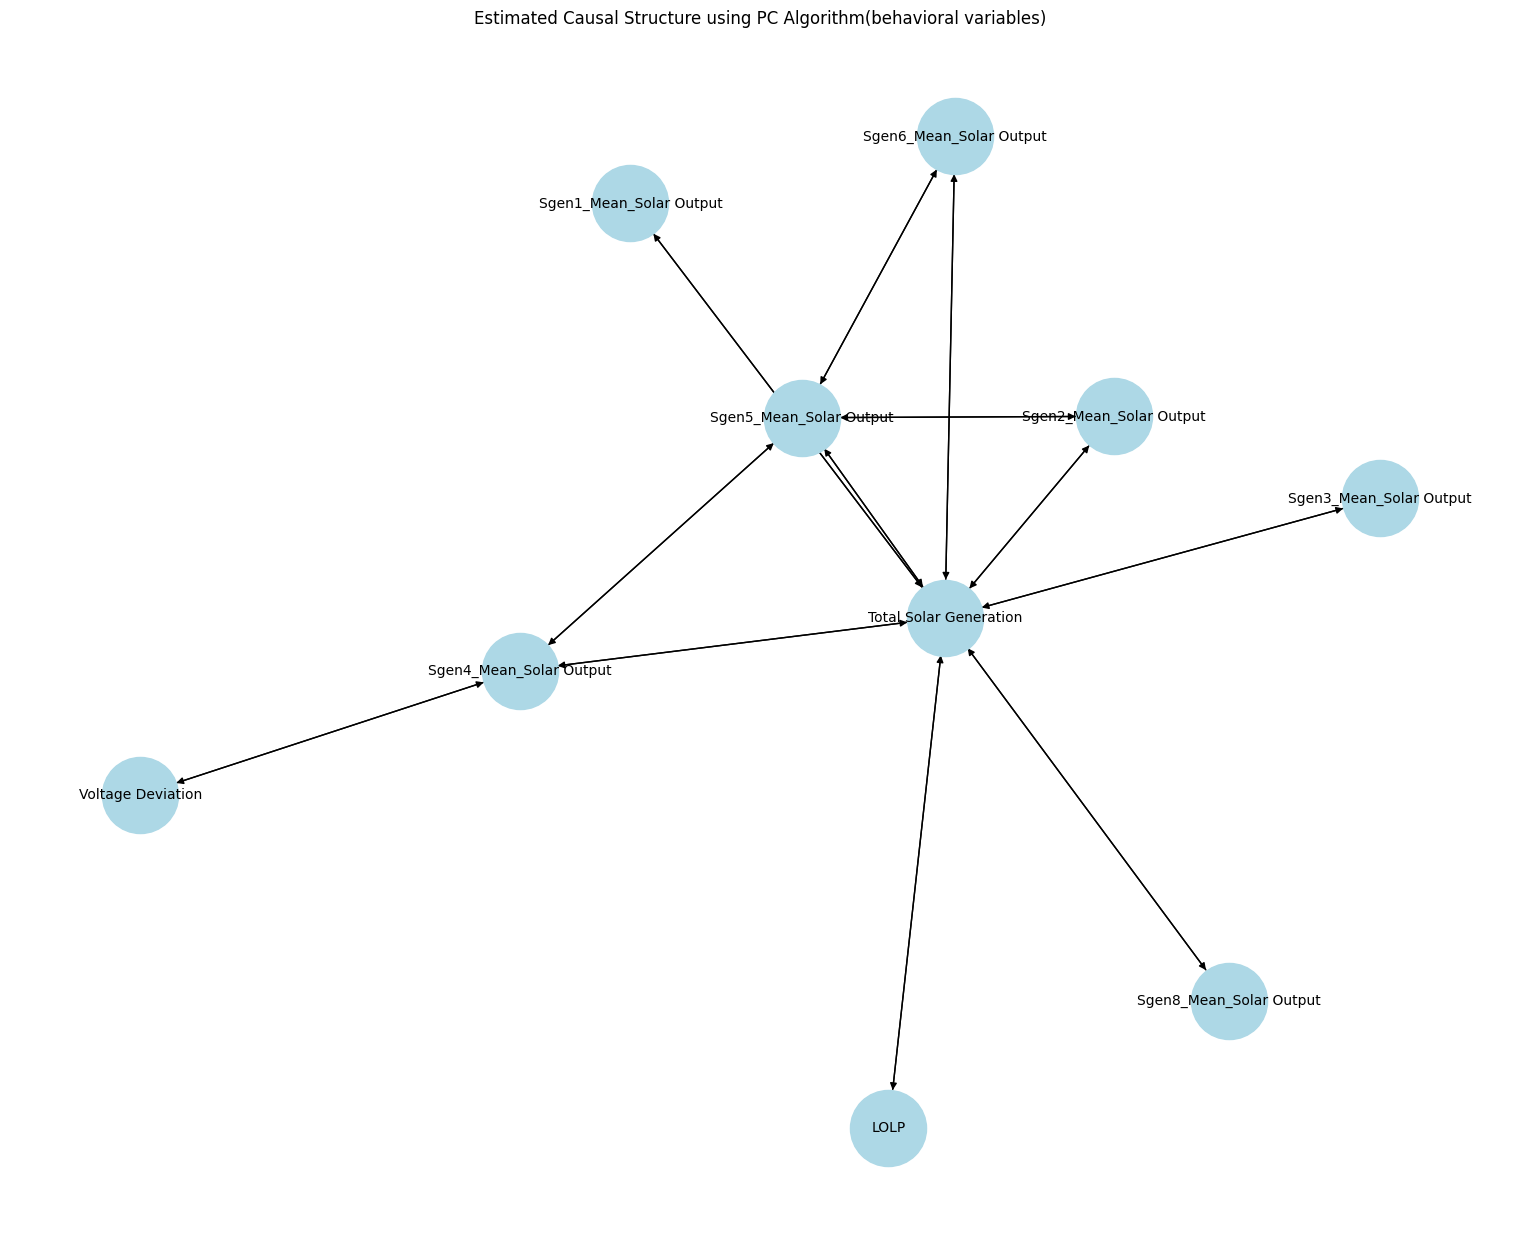

In [32]:
# Apply Peter-Clark Algorithm to Discover Causal Skeleton structire
# Which calculates the Partial correlation between any two variables i and j, conditioned on a set of variables k.
print("Running PC Algorithm for Causal Graph Construction...")

pc_bv_alg = pc(df_bv_scaled.to_numpy(), alpha=0.05)  # Conditional Independence test
causal_graph = pc_bv_alg.G

# Convert causal learn graph to NetworkX format
pc_nx_graph = nx.DiGraph() # Skeleton of the Causal graph

# Extract edges and add them to NetworkX graph
for i, j in zip(*np.where(causal_graph.graph != 0)):  
    pc_nx_graph.add_edge(df_selected_bv.columns[i], df_selected_bv.columns[j])  # Add edges using column names

# Draw the causal graph
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(pc_nx_graph)  # Layout for better visualization
nx.draw(pc_nx_graph, pos, with_labels=True, node_color='lightblue', edge_color='black', node_size=3000, font_size=10)
plt.title("Estimated Causal Structure using PC Algorithm(behavioral variables)")
plt.show()

### Apply IGCI for Causal Drectionality

In [33]:
from __future__ import division
import numpy as np
from scipy.special import psi

def igci(x, y, refMeasure=1, estimator=2):
    """
    Information-Geometric Causal Inference (IGCI) method.

    Parameters:
        x (numpy.ndarray): 1D array representing variable X.
        y (numpy.ndarray): 1D array representing variable Y.
        refMeasure (int): Reference measure for scaling (1: min-max, 2: standardization).
        estimator (int): Estimation method (1: entropy-based, 2: slope-based).

    Returns:
        float: Causal asymmetry score f(x → y), higher values indicate stronger causal direction.
    """

    xi = np.real(x).reshape(-1, 1)
    yi = np.real(y).reshape(-1, 1)

    Lx, dimx = xi.shape
    Ly, dimy = yi.shape

    # ----- Input validation -----
    if dimx != 1 or dimy != 1:
        raise ValueError("Both x and y must be 1D arrays.")

    if Lx < 20 or Ly < 20:
        raise ValueError("Not enough observations in x or y (must be > 20).")

    if Lx != Ly:
        raise ValueError("Lengths of x and y must be equal.")
    # ----------------------------

    # Apply reference measure scaling
    if refMeasure == 1:  # Min-max normalization
        xi = (xi - np.min(xi)) / (np.max(xi) - np.min(xi))
        yi = (yi - np.min(yi)) / (np.max(yi) - np.min(yi))
    elif refMeasure == 2:  # Standardization
        xi = (xi - np.mean(xi)) / np.std(xi)
        yi = (yi - np.mean(yi)) / np.std(yi)
    else:
        print("Warning: Unknown reference measure - no scaling applied.")
        return None

    # ----- Estimation methods -----
    if estimator == 1:
        # Entropy-based estimator
        x1 = np.sort(xi, axis=0)
        y1 = np.sort(yi, axis=0)

        n1 = x1.shape[0]
        hx = np.sum(np.log(np.abs(np.diff(x1)))) / (n1 - 1) + psi(n1) - psi(1)

        n2 = y1.shape[0]
        hy = np.sum(np.log(np.abs(np.diff(y1)))) / (n2 - 1) + psi(n2) - psi(1)

        return hy - hx

    elif estimator == 2:
        # Slope-based estimator
        a, b = 0, 0

        ind1 = np.argsort(xi, axis=0)
        ind2 = np.argsort(yi, axis=0)

        for i in range(Lx - 1):
            # Compute slopes in x → y direction
            X1, X2 = xi[ind1[i, 0], 0], xi[ind1[i + 1, 0], 0]
            Y1, Y2 = yi[ind1[i, 0], 0], yi[ind1[i + 1, 0], 0]
            if (X1 != X2) and (Y1 != Y2):
                a += np.log(np.abs((Y2 - Y1) / (X2 - X1)))

            # Compute slopes in y → x direction
            X1, X2 = xi[ind2[i, 0], 0], xi[ind2[i + 1, 0], 0]
            Y1, Y2 = yi[ind2[i, 0], 0], yi[ind2[i + 1, 0], 0]
            if (X1 != X2) and (Y1 != Y2):
                b += np.log(np.abs((X2 - X1) / (Y2 - Y1)))

        return (a - b) / Lx

    else:
        raise ValueError("Unknown estimator. Use 1 (entropy-based) or 2 (slope-based).")


Applying IGCI Algorithm for Causal Direction...


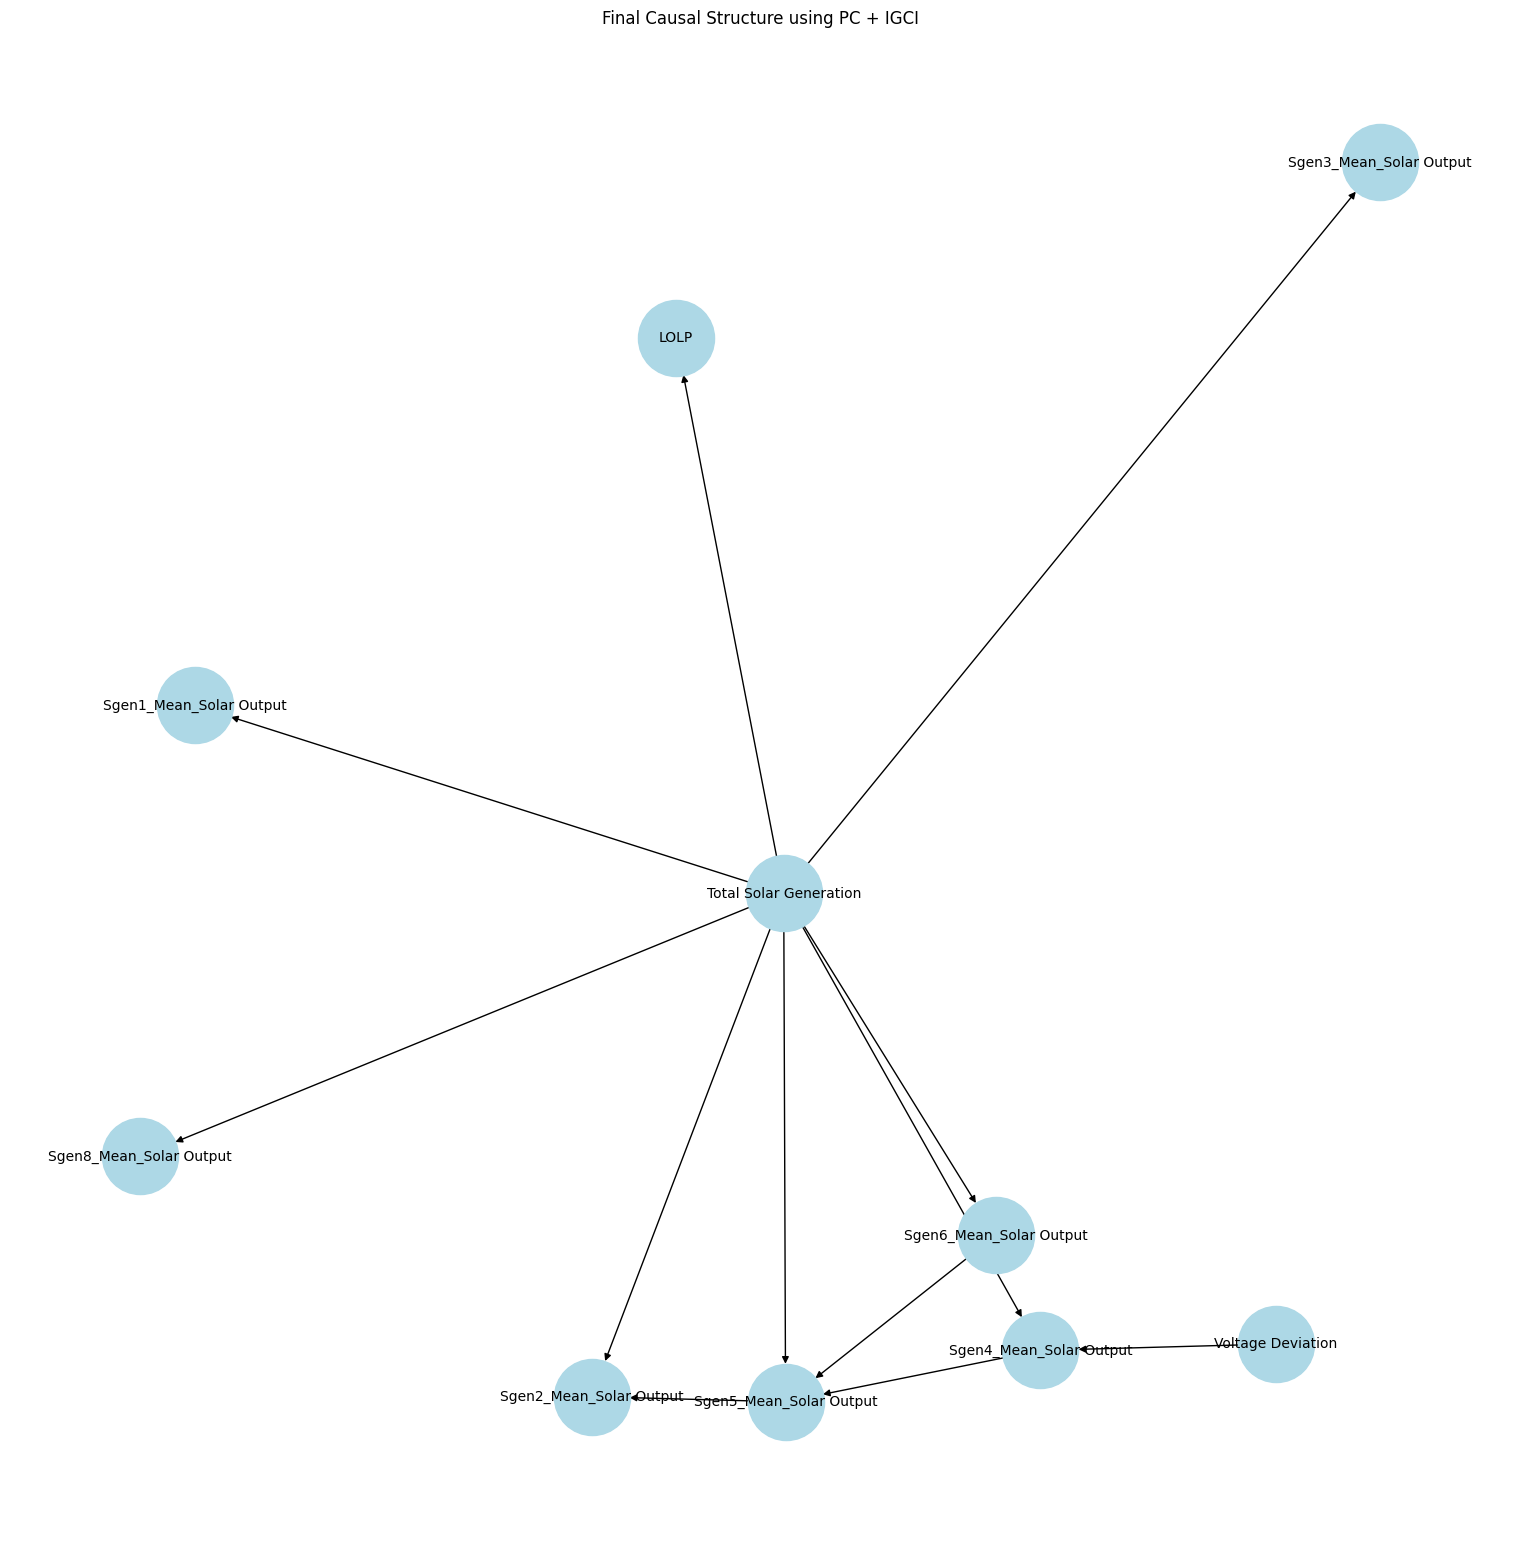

In [35]:
# Apply IGCI for Causal Drectionality
print("Applying IGCI Algorithm for Causal Direction...")
directed_graph = nx.DiGraph()  # Directed graph after IGCI
for edge in pc_nx_graph.edges():
    var_x, var_y = edge
    x_values = df_bv_scaled[var_x].values
    y_values = df_bv_scaled[var_y].values
    
    # Compute IGCI score
    igci_score = igci(x_values, y_values)  # Implement IGCI scoring method
    if igci_score > 0:  # X → Y
        directed_graph.add_edge(var_x, var_y)
    else:  # Y → X
        directed_graph.add_edge(var_y, var_x)

# Visualize the Final Causal Graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(directed_graph)  # Layout for better visualization
nx.draw(directed_graph, pos, with_labels=True, node_color='lightblue', edge_color='black', node_size=3000, font_size=10, arrows=True)
plt.title("Final Causal Structure using PC + IGCI")
plt.show()

### Structural topology variables with LOLP

In [51]:
#structural topology variables
selected_columns_sv= ['Shortest Gen-to-Gen Impedance', 'Longest Gen-to-Gen Impedance',
    'Shortest Load-to-Load Impedance', 'Longest Load-to-Load Impedance',
    'Shortest Gen-to-Load Impedance', 'Longest Gen-to-Load Impedance','LOLP'
]
df_selected_sv= df[selected_columns_sv]

In [40]:
# Standardize the data arrays and create the data object
scaler = StandardScaler()
df_sv_scaled = pd.DataFrame(scaler.fit_transform(df_selected_sv), columns=df_selected_sv .columns)
# Check for NaN values
print("Missing Values Check:")
print(df_sv_scaled.isna().sum())

# Check for infinite values
if np.any(np.isinf(df_sv_scaled.to_numpy())):
    print(" Warning: Infinite values detected in the dataset!")

# Drop NaN values
df_sv_scaled= df_sv_scaled.dropna()  

Missing Values Check:
Shortest Gen-to-Gen Impedance      0
Longest Gen-to-Gen Impedance       0
Shortest Load-to-Load Impedance    0
Longest Load-to-Load Impedance     0
Shortest Gen-to-Load Impedance     0
Longest Gen-to-Load Impedance      0
LOLP                               0
dtype: int64


Running PC Algorithm for Causal Graph Construction...


  0%|          | 0/7 [00:00<?, ?it/s]

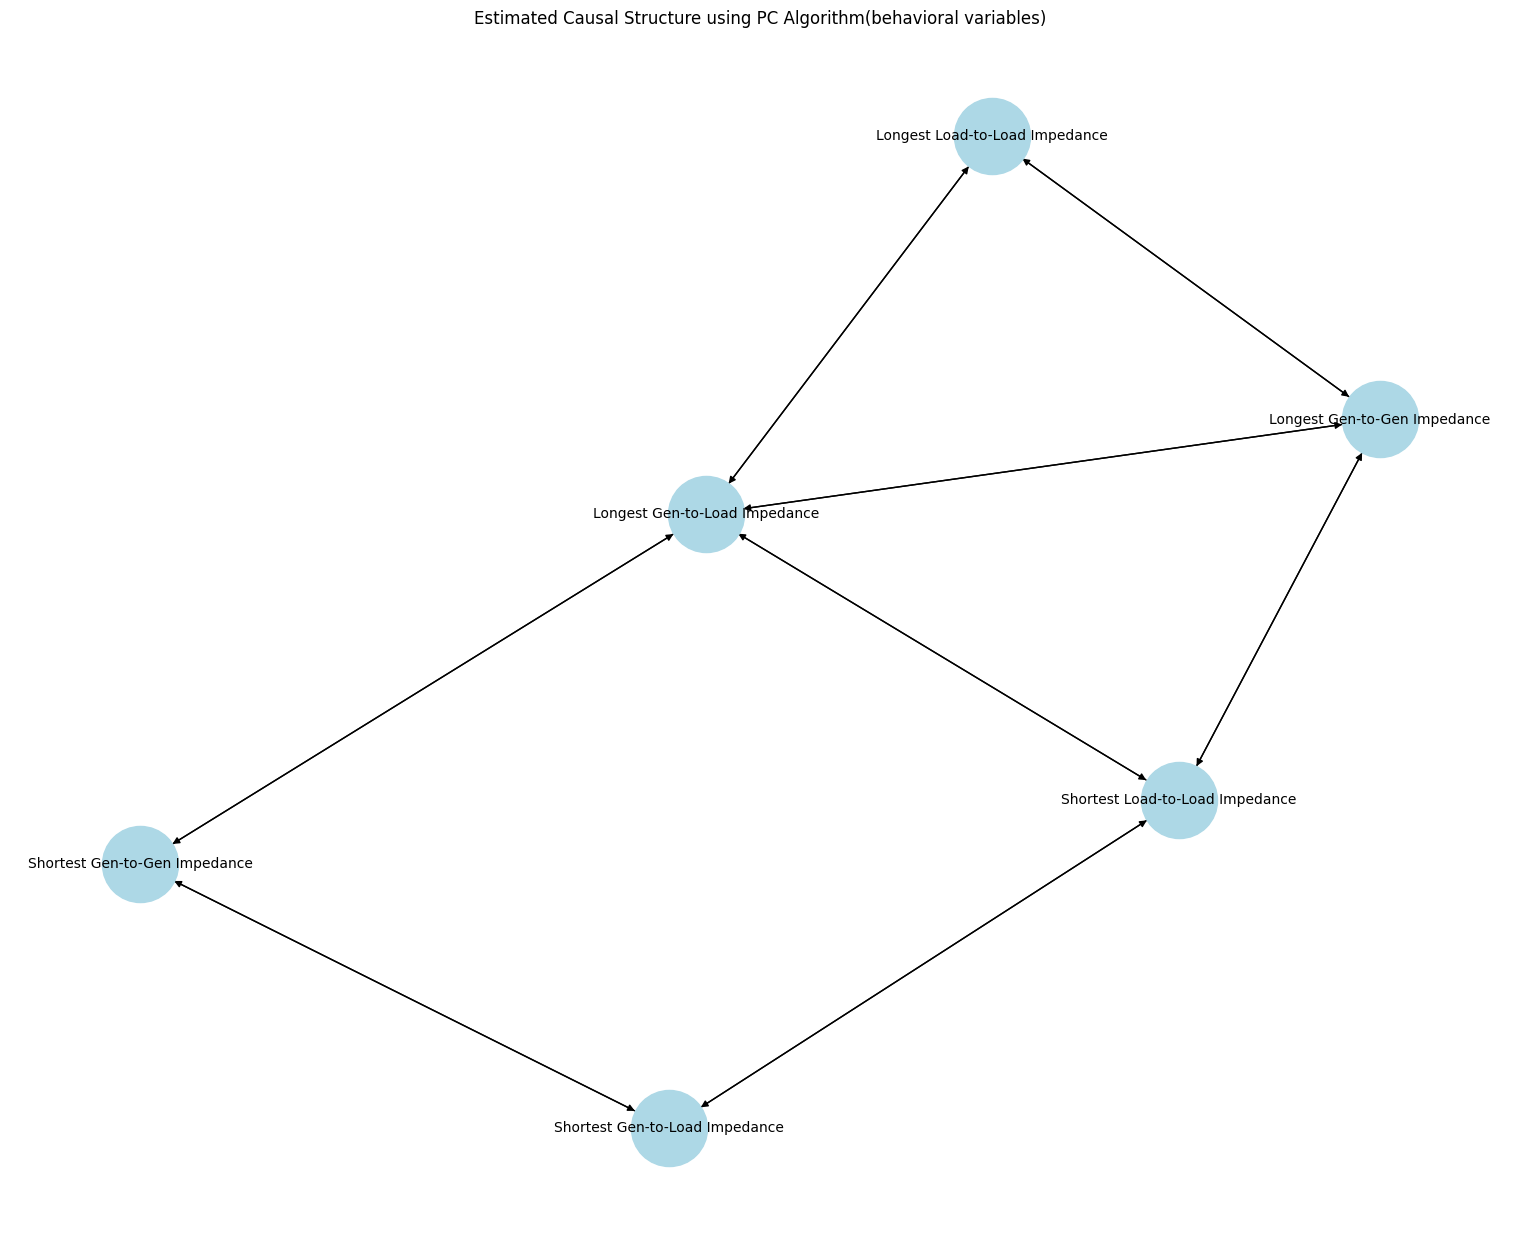

In [49]:
# Apply Peter-Clark Algorithm to Discover Causal Skeleton 
# Which calculates the Partial correlation between any two variables i and j, conditioned on a set of variables k.
print("Running PC Algorithm for Causal Graph Construction...")

pc_sv_alg = pc(df_sv_scaled.to_numpy(), alpha=0.05)  # Conditional Independence test
causal_sv_graph = pc_sv_alg.G 

# Convert causal learn graph to NetworkX format
pc_nx_graph = nx.DiGraph() # Skeleton of the Causal graph

# Extract edges and add them to NetworkX graph
for i, j in zip(*np.where(causal_sv_graph.graph != 0)):  
    pc_nx_graph.add_edge(df_sv_scaled.columns[i], df_sv_scaled.columns[j])  # Add edges using column names

# Draw the causal graph
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(pc_nx_graph)  # Layout for better visualization
nx.draw(pc_nx_graph, pos, with_labels=True, node_color='lightblue', edge_color='black', node_size=3000, font_size=10)
plt.title("Estimated Causal Structure using PC Algorithm(behavioral variables)")
plt.show()


Applying IGCI Algorithm for Causal Direction...


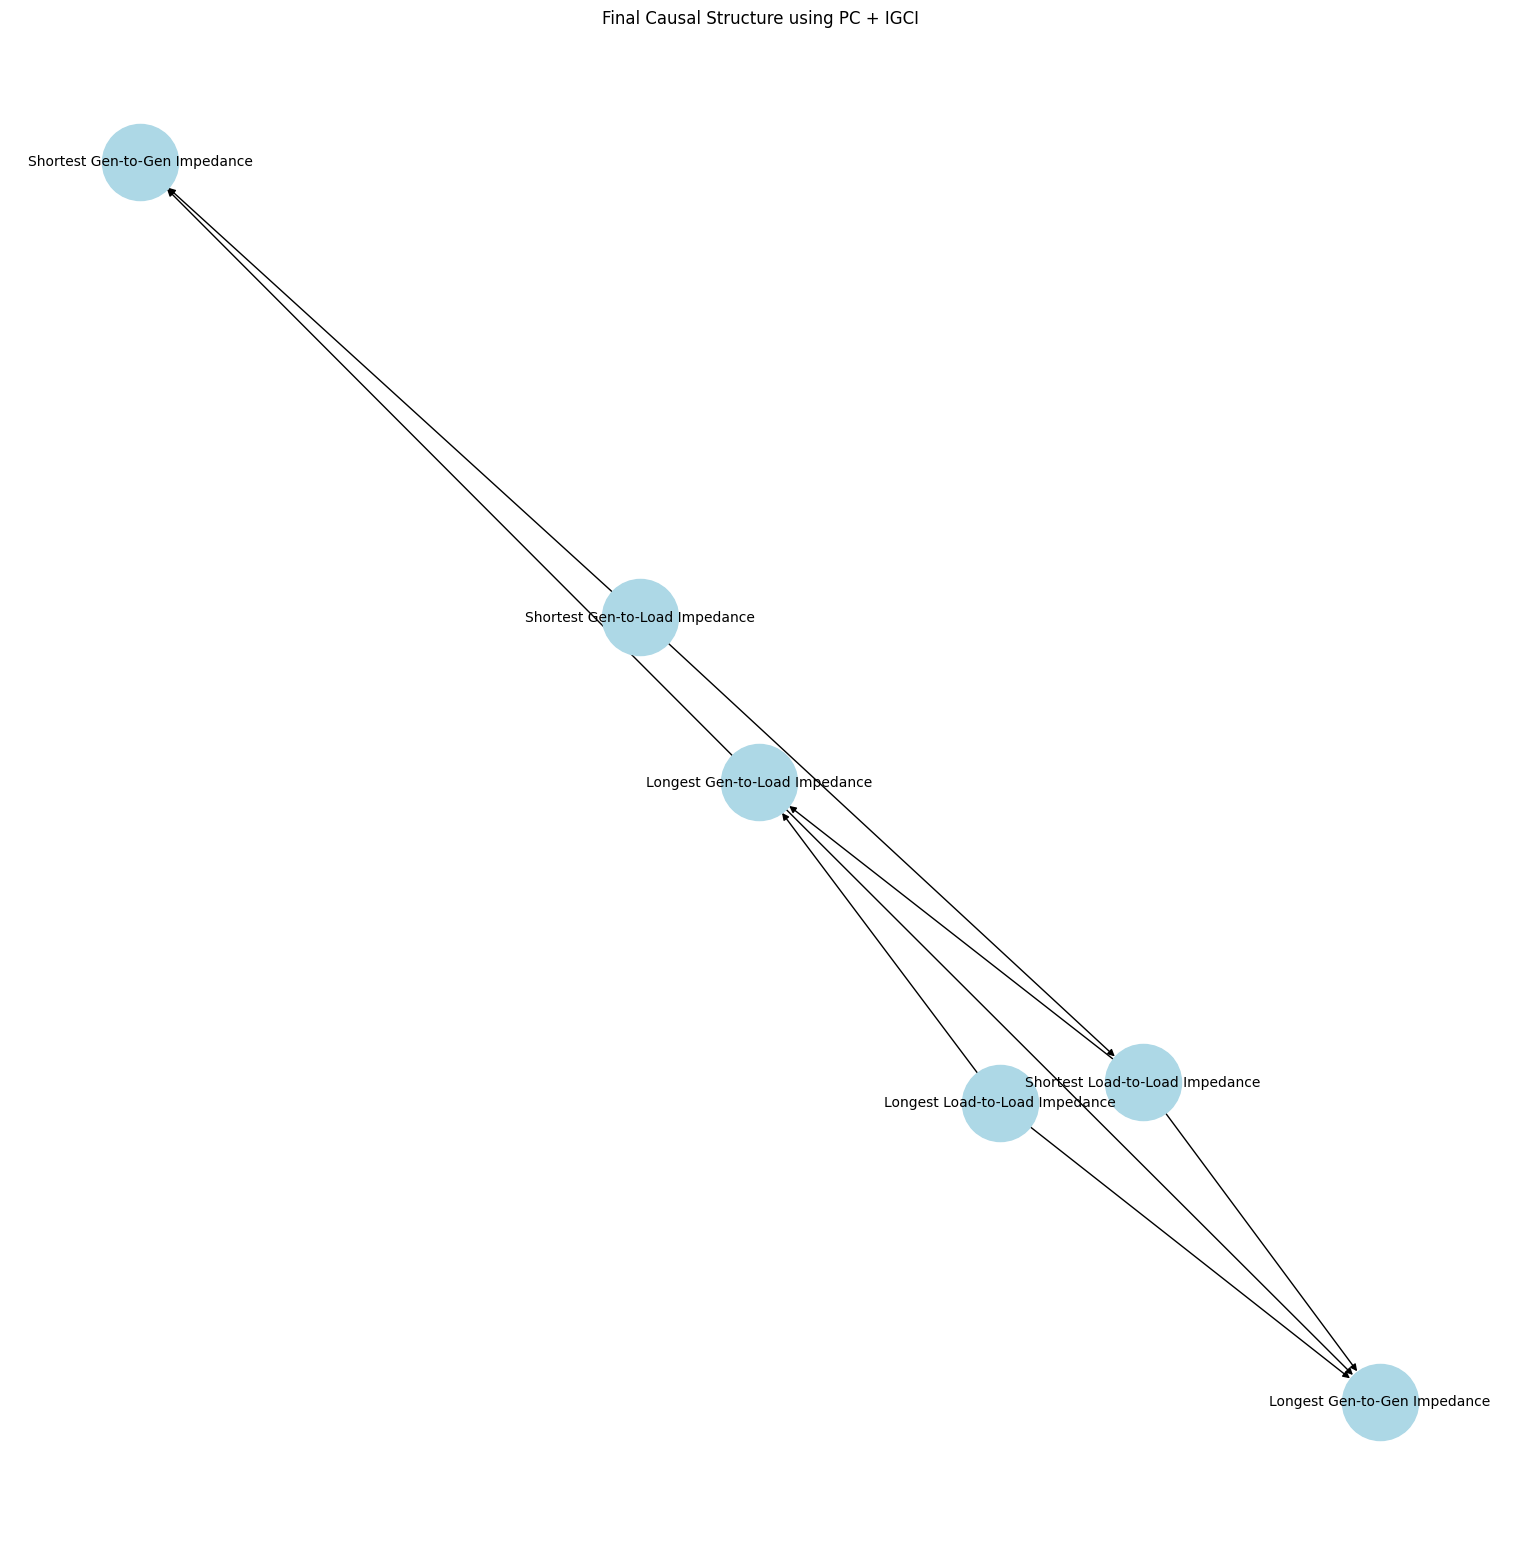

In [50]:
# Apply IGCI for Causal Drectionality
print("Applying IGCI Algorithm for Causal Direction...")
directed_graph = nx.DiGraph()  # Directed graph after IGCI
for edge in pc_nx_graph.edges():
    var_x, var_y = edge
    x_values = df_sv_scaled[var_x].values
    y_values = df_sv_scaled[var_y].values
    
    # Compute IGCI score
    igci_score = igci(x_values, y_values)  # Implement IGCI scoring method
    if igci_score > 0:  # X → Y
        directed_graph.add_edge(var_x, var_y)
    else:  # Y → X
        directed_graph.add_edge(var_y, var_x)

# Visualize the Final Causal Graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(directed_graph)  # Layout for better visualization
nx.draw(directed_graph, pos, with_labels=True, node_color='lightblue', edge_color='black', node_size=3000, font_size=10, arrows=True)
plt.title("Final Causal Structure using PC + IGCI")
plt.show()

### Assign the scaled solar generation to the static generator 

In [17]:
# # Assign the scaled generation to the static generator at 5 PV buses as injected photovoltaic output based on their capacities
# for i, bus in enumerate(pv_buses):
#     # Calculate the proportion of generation for each PV bus
#     bus_scaling_factor = installed_capacities[i] / total_installed_capacity
#     bus_generation_profile = scaled_pv_generation * bus_scaling_factor

#     # Add the generation profile to the DataFrame with a consistent column name
#     column_name = f'bus_{bus}_p_mw'
#     profiles_df[column_name] = bus_generation_profile.astype(float).values
#     # profiles_df[column_name] = bus_generation_profile.values

#     # Create a DFData object with the profiles DataFrame
#     data_source = DFData(profiles_df)

#     # Create ConstControl objects for each PV bus to update active power over time
#     for i, bus in enumerate(pv_buses):
#         element_index = net.sgen[net.sgen['bus'] == bus].index[0]
#         column_name = f'bus_{bus}_p_mw'
#         ConstControl(net, element='sgen', variable='p_mw', element_index=element_index, data_source=data_source,
#                      profile_name=column_name)    

## Time-Series Simulation
Runs the power flow simulation iteratively for each time step. After each step, it computes the power flow and stores the results.

In [18]:
# Set up the output writer for results
# output_dir = "D:/My workspace/Results"#Home PC
output_dir = "C:/Apps-SU/My workspace/" #Lab PC
ow = OutputWriter(net, output_path=output_dir, output_file_type=".xlsx")
# Define record
ow.log_variable('res_sgen', 'p_mw')

# Define the number of time steps for the simulation
# time_steps = range(len(profiles_df))  # Define time steps as a range matching the data length
time_steps = list(range(0, 8760))
# Run the time-series simulation with the defined number of time steps
run_timeseries(net, time_steps=time_steps)

100%|██████████| 8760/8760 [01:10<00:00, 124.01it/s]


## Plot the PV Buses Power Function

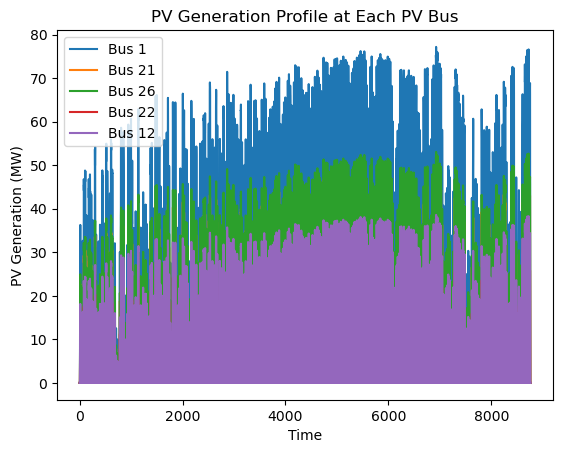

In [19]:
# Assuming the Excel file has columns corresponding to the first 5 buses for PV generation profiles
# Define the output directory and updated file path for res_sgen
output_dir = "C:/Apps-SU/My workspace/res_sgen/"
result_file_path = os.path.join(output_dir, "p_mw.xlsx")
try:
    # Load the data from p_mw.xlsx for plotting
    pv_generation_data = pd.read_excel(result_file_path, usecols="B:F")  # Load columns B to F (2nd to 6th columns)
    plt.figure()
    plt.title('PV Generation Profile at Each PV Bus')

    # Plot each bus's generation profile from the loaded data
    for i, bus in enumerate(pv_buses):
        plt.plot(pv_generation_data.iloc[:, i], label=f'Bus {bus}')  # Use column for bus

    plt.xlabel('Time')
    plt.ylabel('PV Generation (MW)')
    plt.legend()
    plt.show()

except FileNotFoundError:
    print(f"File not found: {result_file_path}")

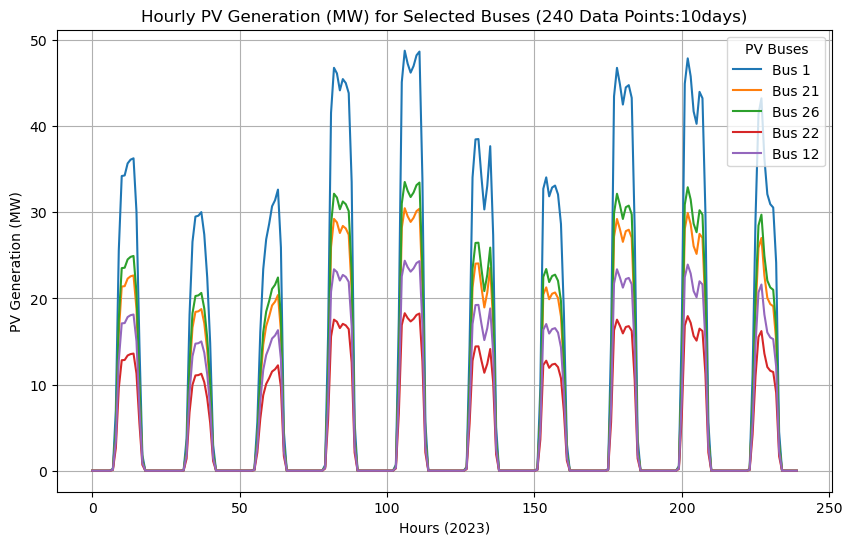

In [20]:
# Plotting the first 240 data points for each bus
plt.figure(figsize=(10, 6))
for i, bus in enumerate(pv_buses):
    plt.plot(pv_generation_data.index[:240], pv_generation_data.iloc[:240, i], label=f'Bus {bus}')

# Setting labels and title
plt.xlabel('Hours (2023)')
plt.ylabel('PV Generation (MW)')
plt.title('Hourly PV Generation (MW) for Selected Buses (240 Data Points:10days)')
plt.legend(title="PV Buses")
plt.grid(True)
plt.show()

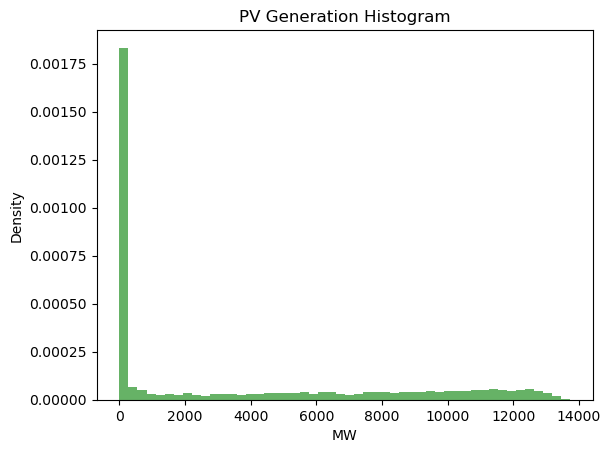

In [21]:
# Plot histogram of the data to visually inspect distribution
plt.hist(pv_generation, bins=50, density=True, alpha=0.6, color='g')
plt.title("PV Generation Histogram")
plt.xlabel("MW")
plt.ylabel("Density")
plt.show()

## Perform optimal power flow (OPF) analysis

In [22]:
pp.runopp(net)
print("OPF Results:")
print(net.res_bus)
print(net.res_line)

OPF Results:
       vm_pu  va_degree       p_mw     q_mvar     lam_p         lam_q
0   1.000000   0.000000 -39.448392  19.949940  3.577936 -4.143238e-03
1   1.004029  -0.836057 -31.402858  -5.477128  3.608594 -2.971973e-08
2   0.999105  -2.239730   2.400000   1.200000  3.671995  4.266441e-03
3   0.999526  -2.655931   7.600000   1.600000  3.689274  5.221961e-03
4   0.995485  -2.371100   0.000000  -0.188288  3.660976  1.874167e-02
5   0.995131  -2.952487   0.000000   0.000000  3.694853  2.294117e-02
6   0.985949  -3.252072  22.800000  10.900000  3.715213  3.591101e-02
7   0.983916  -3.354916  30.000000  30.000000  6.855822  3.079593e+00
8   1.012731  -3.826598   0.000000   0.000000  3.760950  4.003894e-02
9   1.022042  -4.272397   5.800000   2.000000  3.794853  4.798086e-02
10  1.012731  -3.826598   0.000000   0.000000  3.760950  4.003829e-02
11  1.044342  -4.355654  11.200000   7.500000  3.756287  1.369208e-03
12  1.099003  -3.298512 -15.125197 -43.047720  3.756254  3.822850e-04
13  1.0

### The Mean and Standard Deviation values for each Static Generator(solar based energy) on the Pv bus

In [23]:
# Calculate mean and std for each PV bus from 2023 data
pv_bus_means =  pv_generation_data.mean()
pv_bus_stds =  pv_generation_data.std()

# Print the mean and standard deviation for each PV bus
print("Mean Generation for each PV bus:\n", pv_bus_means )
print("\nStandard Deviation for each PV bus:\n", pv_bus_stds)

Mean Generation for each PV bus:
 0    20.42496
1    12.76560
2    14.04216
3     7.65936
4    10.21248
dtype: float64

Standard Deviation for each PV bus:
 0    25.622111
1    16.013819
2    17.615201
3     9.608292
4    12.811055
dtype: float64


 ## Monte Carlo Analysis for the System Reliability

In [24]:
# Set the number of Monte Carlo simulations
num_simulations = 8760

In [25]:
# ReLoad the 30-bus system model
net = pn.case30()
# Initialize arrays to store results
lolp_count = 0  # Count of loss of load events
unmet_demand_hours = 0  # Total hours of unmet demand

# Add static (PV) and traditional generators to each PV bus
for i, bus in enumerate(pv_buses):
    # Traditional generator (voltage-controlled generator)
    if f"Traditional_gen_{bus}" not in net.gen['name'].values:
        pp.create_gen(net, bus, p_mw=0, vm_pu=1.00, max_p_mw=50, name=f"Traditional_gen_{bus}")
    # Photovoltaic generator as a static generator (sgen)
    if f"PV_sgen_{bus}" not in net.sgen['name'].values:
        pp.create_sgen(net, bus, p_mw=pv_bus_means[i], max_p_mw=pv_bus_means[i] + pv_bus_stds[i], name=f"PV_sgen_{bus}")
        
# Run Monte Carlo simulations
for sim in range(num_simulations):
    # Sample PV generation for each bus
    pv_samples = [np.random.normal(pv_bus_means[i], pv_bus_stds[i]) for i in range(len(pv_buses))]
    
    # Assign PV generation to static generators
    for i, bus in enumerate(pv_buses):
        pv_sgen_index = net.sgen[net.sgen['bus'] == bus].index[0]
        net.sgen.at[pv_sgen_index, 'p_mw'] = pv_samples[i]
    
    # Run power flow
    pp.runpp(net)
    
    # Check for unmet demand
    total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
    total_load = net.load['p_mw'].sum()
    
    if total_generation < total_load:
        lolp_count += 1
        unmet_demand_hours += 1

# Calculate reliability metrics
lolp = lolp_count / num_simulations
lole = lolp * num_simulations

print(f"Loss of Load Probability (LOLP): {lolp}")
print(f"Loss of Load Expectation (LOLE) over {num_simulations} hours: {lole}")

Loss of Load Probability (LOLP): 0.14143835616438355
Loss of Load Expectation (LOLE) over 8760 hours: 1239.0


## Generate structured datasets for Causal Inference Analysis
Link the 5 PV bus outputs and other variables to the system reliability indicator's results.<br
                                                                                                   >
Build structured datasets, each scenario with varying PV generation profiles and system reliability outcomes.

In [26]:
# ReLoad the 30-Bus power system
net = pn.case30()

# Number of random scenarios
n_scenarios = 300

# Initialize a list to store structured datasets
structured_data = []

# Add static (PV) and traditional generators (Voltage control) to each PV bus 
for i, bus in enumerate(pv_buses):
    # Traditional generator (voltage-controlled generator)
    if f"Traditional_gen_{bus}" not in net.gen['name'].values:
       pp.create_gen(net, bus, p_mw=0, vm_pu=1.00, max_p_mw=50, name=f"Traditional_gen_{bus}")
    # Photovoltaic generator as a static generator (sgen)
    if f"PV_sgen_{bus}" not in net.sgen['name'].values:
       pp.create_sgen(net, bus, p_mw=0, max_p_mw=installed_capacity, name=f"PV_sgen_{bus}")

# Loop through scenarios to update sgen values
for scenario in range(n_scenarios):
    # Sample PV outputs from the normal distribution
    pv_outputs = [max(0, np.random.normal(mean, std)) for mean, std in zip(pv_bus_means, pv_bus_stds)]
    # Update the p_mw values for the PV static generators (sgen)
    for i, bus in enumerate(pv_buses):
        net.sgen.loc[net.sgen['name'] == f"PV_sgen_{bus}", 'p_mw'] = pv_outputs[i]

# Run power flow 
    try:
        pp.runpp(net)
        
        # Calculate reliability indicators (LOLP)
        total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
        total_load = net.load['p_mw'].sum()
        lolp = 1 if total_generation < total_load else 0  # LOLP calculation

        total_reactive_power = net.res_gen['q_mvar'].sum() + net.res_sgen['q_mvar'].sum()  # Total reactive power
        voltage_deviation = net.res_bus['vm_pu'].std()  # Standard deviation of bus voltages
        
        # Collect scenario data
        scenario_data = {
            'Scenario': scenario + 1,
            'PV1 Output': pv_outputs[0],
            'PV2 Output': pv_outputs[1],
            'PV3 Output': pv_outputs[2],
            'PV4 Output': pv_outputs[3],
            'PV5 Output': pv_outputs[4],
            'Total Solar Generation': net.res_sgen['p_mw'].sum(),
            'Total Reactive Power': total_reactive_power,
             'Voltage Deviation': voltage_deviation,
            'Total Load': total_load,
            'LOLP': lolp
        }
        structured_data.append(scenario_data)
    except pp.LoadflowNotConverged:
        print(f"Scenario {scenario + 1}: Power flow did not converge.")
        continue
    
# Convert results to a DataFrame
df_results = pd.DataFrame(structured_data)

# Save results to an Excel file
df_results.to_excel("structured_data_30bus_cases.xlsx", index=False)
print("Structured data saved to 'structured_data_30bus_cases.xlsx'.")

Structured data saved to 'structured_data_30bus_cases.xlsx'.


### Load the Experimental Results

In [27]:
import dowhy
from dowhy import CausalModel

In [28]:
data = pd.read_excel('structured_data_30bus_cases.xlsx')
# View data structure
print(data.head())

   Scenario  PV1 Output  PV2 Output  PV3 Output  PV4 Output  PV5 Output  \
0         1    0.000000    6.393316   27.201030    0.000000    0.000000   
1         2    0.000000   19.166547   28.025689    2.440544    9.791505   
2         3   34.797904   22.605885   15.125026    4.626306    0.000000   
3         4    0.000000   22.407202    0.000000    2.403235    9.553918   
4         5    7.935244   39.081118   13.709257    0.000000    0.058978   

   Total Solar Generation  Total Reactive Power  Voltage Deviation  \
0               33.594346             94.378938           0.011466   
1               59.424284             90.136944           0.011570   
2               77.155121             80.056367           0.011759   
3               34.364355             92.618102           0.011687   
4               60.784597             85.873080           0.011879   

   Total Load  LOLP  
0       189.2     0  
1       189.2     0  
2       189.2     0  
3       189.2     0  
4       189.2     

### Define the Causal Model and  Estimate the Causal Effect

Analyzing causal effect of PV1 Output on LOLP:


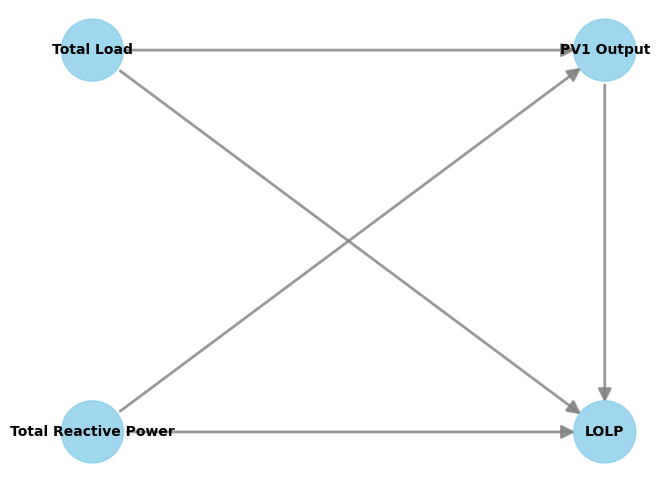

Causal Effect of PV1 Output on LOLP: 0.0037090191749719822


Analyzing causal effect of PV2 Output on LOLP:


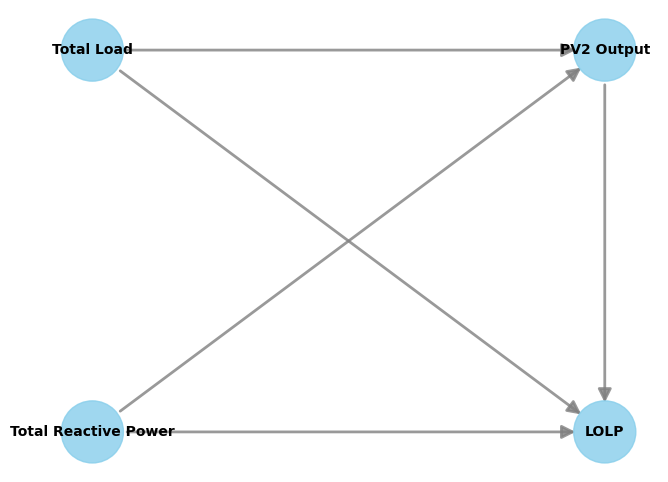

Causal Effect of PV2 Output on LOLP: -0.00039432930504116476


Analyzing causal effect of PV3 Output on LOLP:


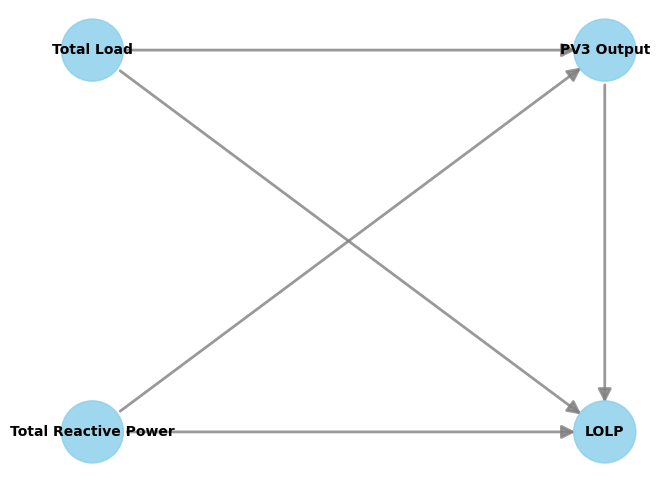

Causal Effect of PV3 Output on LOLP: -0.0018435076073529746


Analyzing causal effect of PV4 Output on LOLP:


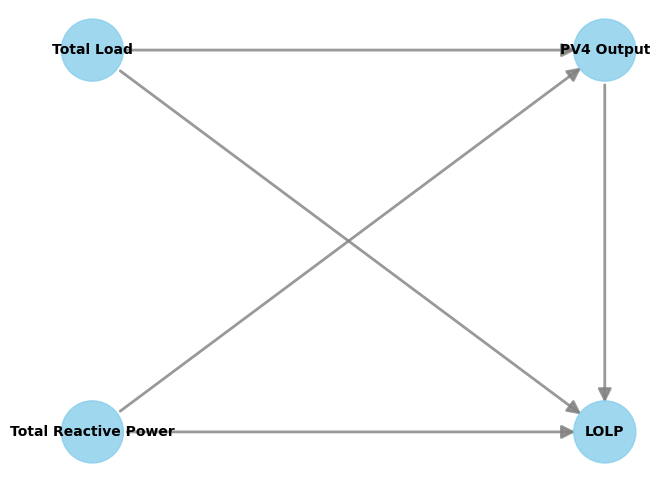

Causal Effect of PV4 Output on LOLP: -0.0008868022422847954


Analyzing causal effect of PV5 Output on LOLP:


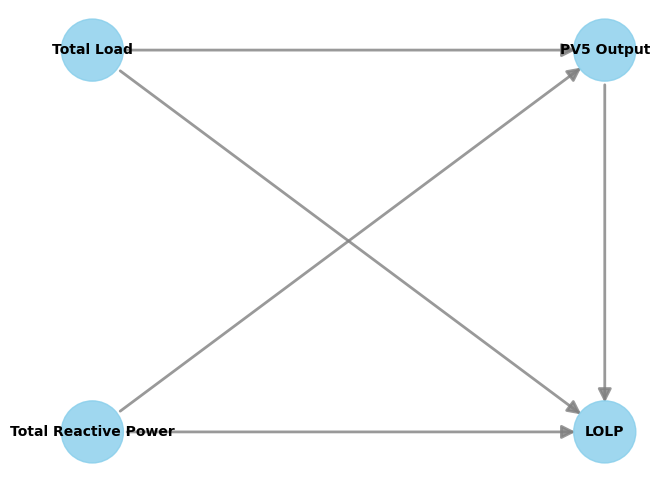

Causal Effect of PV5 Output on LOLP: -0.0021631845624823925




In [54]:
# Iterate over each PV bus output as the treatment variable
pv_buses = ['PV1 Output', 'PV2 Output', 'PV3 Output', 'PV4 Output', 'PV5 Output']

for pv_bus in pv_buses:
    print(f"Analyzing causal effect of {pv_bus} on LOLP:")
    # Define the causal model
    model = CausalModel(
    data=data,
    treatment=pv_bus,  # Treatments
    outcome='LOLP',  # Reliability indicator
    common_causes=['Total Load', 'Total Reactive Power']  # Confounders
)
    # Visualize the DAG
    model.view_model()

# Identify and estimate the causal effect
    identified_estimand = model.identify_effect()
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"
    )
    
    print(f"Causal Effect of {pv_bus} on LOLP: {causal_estimate.value}")
    print("\n")


### Improvement: Make Photovoltaic generators more significant in the system
Make some improvements and refine the project, drop off some traditional generators(first check them and turn off some, to make sgen generator (pv generation) more significant, and then change the mean and std of the 5 PV buses（assume they all follow a normal distribution) to generate different scenarios.<br> Each scenario includes hundreds of run times(stochastic) and can consider the Monte Carlo method to get a corresponding lolp value(for example 0.734.)

In [133]:
# ReLoad the 30-Bus power system
net = pn.case30()     
# Inspect generators in the system
print(net.gen)

   name  bus   p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1  60.97    1.0     NaN       -20.0        60.0      1.0  False   
1  None   21  21.59    1.0     NaN       -15.0        62.5      1.0  False   
2  None   26  26.91    1.0     NaN       -15.0        48.7      1.0  False   
3  None   22  19.20    1.0     NaN       -10.0        40.0      1.0  False   
4  None   12  37.00    1.0     NaN       -15.0        44.7      1.0  False   

   in_service  slack_weight  type  controllable  max_p_mw  min_p_mw  
0        True           0.0  None          True      80.0       0.0  
1        True           0.0  None          True      50.0       0.0  
2        True           0.0  None          True      55.0       0.0  
3        True           0.0  None          True      30.0       0.0  
4        True           0.0  None          True      40.0       0.0  


In [134]:
# Drop specific generators

net.gen.drop(net.gen[net.gen['bus'].isin([22])].index, inplace=True)

# Verify the remaining generators
print(net.gen)

   name  bus   p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1  60.97    1.0     NaN       -20.0        60.0      1.0  False   
1  None   21  21.59    1.0     NaN       -15.0        62.5      1.0  False   
2  None   26  26.91    1.0     NaN       -15.0        48.7      1.0  False   
4  None   12  37.00    1.0     NaN       -15.0        44.7      1.0  False   

   in_service  slack_weight  type  controllable  max_p_mw  min_p_mw  
0        True           0.0  None          True      80.0       0.0  
1        True           0.0  None          True      50.0       0.0  
2        True           0.0  None          True      55.0       0.0  
4        True           0.0  None          True      40.0       0.0  


In [135]:
# Verify static generator table
print(net.sgen)

Empty DataFrame
Columns: [name, bus, p_mw, q_mvar, sn_mva, scaling, in_service, type, current_source]
Index: []


In [136]:
# Identify the 5 PV buses in the IEEE 30-bus system
pv_buses = [1, 21, 26, 22, 12]

# Create Static Generators (sgen) for the PV buses
for bus, installed_capacity in zip(pv_buses, installed_capacities):
    pp.create_sgen(net, bus, p_mw=0, max_p_mw=installed_capacity, name=f"PV_bus_{bus}")
    # Verify static generator table
print(net.sgen)

        name  bus  p_mw  q_mvar  sn_mva  scaling  in_service type  \
0   PV_bus_1    1   0.0     0.0     NaN      1.0        True  wye   
1  PV_bus_21   21   0.0     0.0     NaN      1.0        True  wye   
2  PV_bus_26   26   0.0     0.0     NaN      1.0        True  wye   
3  PV_bus_22   22   0.0     0.0     NaN      1.0        True  wye   
4  PV_bus_12   12   0.0     0.0     NaN      1.0        True  wye   

   current_source  max_p_mw  
0            True      80.0  
1            True      50.0  
2            True      55.0  
3            True      30.0  
4            True      40.0  


In [137]:
n_scenarios = 100  # Number of scenarios
n_runs_per_scenario = 500  # Monte Carlo runs per scenario
scenario_results = []
# Acceptable variation (Assume variation with the original mean and std)
mean_variation = 1
std_variation = 1

In [138]:
# Iterate over scenarios
for scenario in range(n_scenarios):
    scenario_lolps = []  # Store LOLP for each run in this scenario

### Generate Scenarios for collect data

In [139]:
# Generate scenarios
for scenario in range(n_scenarios):
    # Adjust mean and std for this scenario
    print(f"Running Scenario {scenario + 1}/{n_scenarios}")
    lolp_count = 0  # To count the number of load losses
    scenario_means = [mean * (1 + np.random.uniform(-mean_variation, mean_variation)) for mean in pv_bus_means]
    scenario_stds = [std * (1 + np.random.uniform(-std_variation, std_variation)) for std in pv_bus_stds]
    
    scenario_lolps = []  # Store LOLP for each run in this scenario
    total_solar_generation = []
    total_reactive_power = []
    voltage_deviations = []
    for run in range(n_runs_per_scenario):
        # Sample PV outputs from normal distribution
        pv_outputs = [max(0, np.random.normal(mean, std)) for mean, std in zip(scenario_means, scenario_stds)]
        
        # Update PV generation in the network
        for i, bus in enumerate(pv_buses):
            net.sgen.loc[net.sgen['bus'] == bus, 'p_mw'] = pv_outputs[i]
        
        try:
            # Run power flow
            pp.runpp(net)
            
            # Calculate metrics
            total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
            total_solar_generation.append(net.res_sgen['p_mw'].sum())
            total_reactive_power.append(net.res_bus['q_mvar'].sum())
            voltage_deviation = np.mean(abs(net.res_bus['vm_pu'] - 1.0))
            voltage_deviations.append(voltage_deviation)
            
            # Calculate voltage deviation from 1.0 p.u.
            voltage_dev = abs(net.res_bus['vm_pu'] - 1).mean()
            voltage_deviations.append(voltage_dev)
            
            # Calculate LOLP
            total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
            total_load = net.load['p_mw'].sum()
            lolp = 1 if total_generation < total_load else 0  # Load loss if generation < load
            scenario_lolps.append(lolp)
        except pp.LoadflowNotConverged:
            print(f"Power flow did not converge for scenario {scenario}, run {run}.")
            continue
    
    # Calculate average LOLP for this scenario
    avg_lolp = np.mean(scenario_lolps) if scenario_lolps else None
    print(f"Scenario {scenario + 1}: Average LOLP = {avg_lolp}")
    avg_solar_generation = np.mean(total_solar_generation)
    avg_reactive_power = np.mean(total_reactive_power)
    avg_voltage_deviation = np.mean(voltage_deviations)
    
    # Calculate LOLP for this scenario
    lolp = lolp_count / n_runs_per_scenario
    scenario_results.append({
        'Scenario': scenario + 1,
        'PV1 Mean Output': scenario_means[0],
        'PV1 Std Output': scenario_stds[0],
        'PV2 Mean Output': scenario_means[1],
        'PV2 Std Output': scenario_stds[1],
        'PV3 Mean Output': scenario_means[2],
        'PV3 Std Output': scenario_stds[2],
        'PV4 Mean Output': scenario_means[3],
        'PV4 Std Output': scenario_stds[3],
        'PV5 Mean Output': scenario_means[4],
        'PV5 Std Output': scenario_stds[4],
        'Total Solar Generation': avg_solar_generation,
        'Total Reactive Power': avg_reactive_power,
        'Voltage Deviation': avg_voltage_deviation,
        'LOLP': avg_lolp
    })

# Save results to a DataFrame
df_scenario_results = pd.DataFrame(scenario_results)
df_scenario_results.to_excel("100_scenarios_drop1_results.xlsx", index=False)
print("Scenario results saved to '100_scenarios_drop1_results.xlsx'.")

Running Scenario 1/100
Scenario 1: Average LOLP = 0.05
Running Scenario 2/100
Scenario 2: Average LOLP = 0.0
Running Scenario 3/100
Scenario 3: Average LOLP = 0.1
Running Scenario 4/100
Scenario 4: Average LOLP = 0.01
Running Scenario 5/100
Scenario 5: Average LOLP = 0.158
Running Scenario 6/100
Scenario 6: Average LOLP = 0.042
Running Scenario 7/100
Scenario 7: Average LOLP = 0.058
Running Scenario 8/100
Scenario 8: Average LOLP = 0.178
Running Scenario 9/100
Scenario 9: Average LOLP = 0.058
Running Scenario 10/100
Scenario 10: Average LOLP = 0.436
Running Scenario 11/100
Scenario 11: Average LOLP = 0.012
Running Scenario 12/100
Scenario 12: Average LOLP = 0.098
Running Scenario 13/100
Scenario 13: Average LOLP = 0.056
Running Scenario 14/100
Scenario 14: Average LOLP = 0.082
Running Scenario 15/100
Scenario 15: Average LOLP = 0.396
Running Scenario 16/100
Scenario 16: Average LOLP = 0.156
Running Scenario 17/100
Scenario 17: Average LOLP = 0.058
Running Scenario 18/100
Scenario 18: A

In [140]:
data = pd.read_excel('100_scenarios_drop1_results.xlsx')
# View data structure
print(data.head())

   Scenario  PV1 Mean Output  PV1 Std Output  PV2 Mean Output  PV2 Std Output  \
0         1        22.001459       32.655702        25.024449       30.656475   
1         2        20.374236        4.573077         4.934383        8.254102   
2         3        38.803690       16.423973         2.782887       30.873262   
3         4        31.621034       10.705823        15.072737       10.991659   
4         5         3.435557       23.048275        15.181540        8.275978   

   PV3 Mean Output  PV3 Std Output  PV4 Mean Output  PV4 Std Output  \
0        17.387559        2.258061         9.186479       11.584503   
1        22.515850        4.844248        12.651198        9.748060   
2         9.218810       15.303972         8.557404       13.845282   
3        18.138888        0.301388         6.825625       15.915841   
4         6.306105       12.880228        13.739654        5.455674   

   PV5 Mean Output  PV5 Std Output  Total Solar Generation  \
0        17.017713      

Analyzing causal effect of PV1 Mean Output on LOLP:


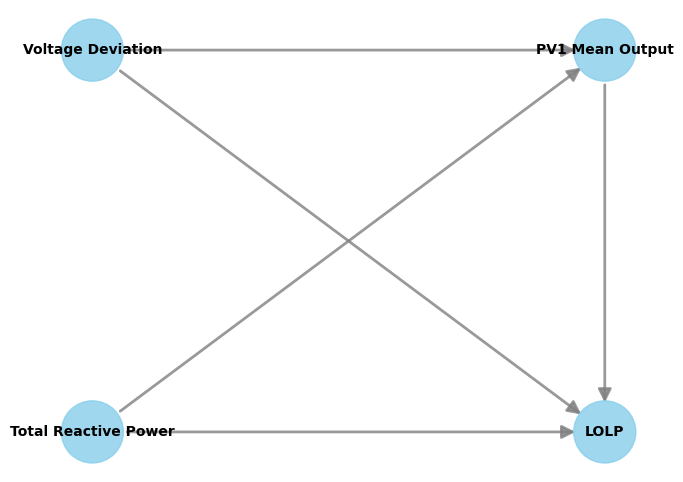

Causal Effect of PV1 Mean Output on LOLP: -0.004355791576428292


Analyzing causal effect of PV2 Mean Output on LOLP:


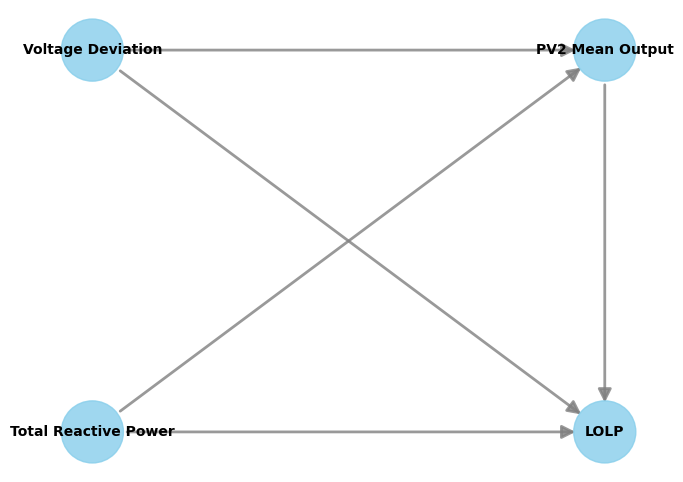

Causal Effect of PV2 Mean Output on LOLP: -0.005948728250451979


Analyzing causal effect of PV3 Mean Output on LOLP:


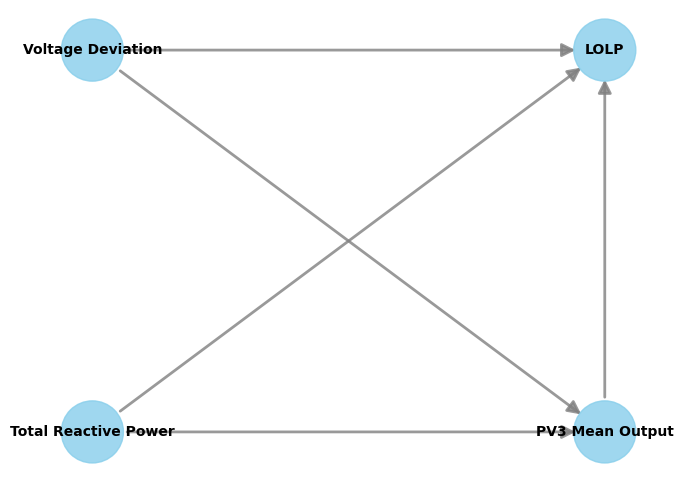

Causal Effect of PV3 Mean Output on LOLP: -0.004124005821265014


Analyzing causal effect of PV4 Mean Output on LOLP:


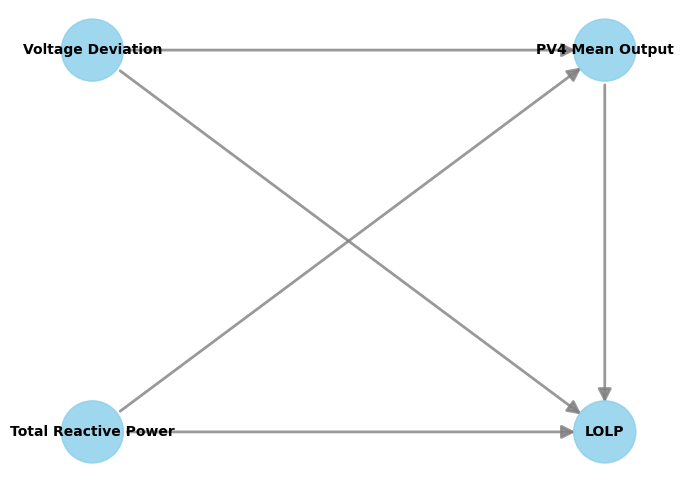

Causal Effect of PV4 Mean Output on LOLP: -0.006589894702130145


Analyzing causal effect of PV5 Mean Output on LOLP:


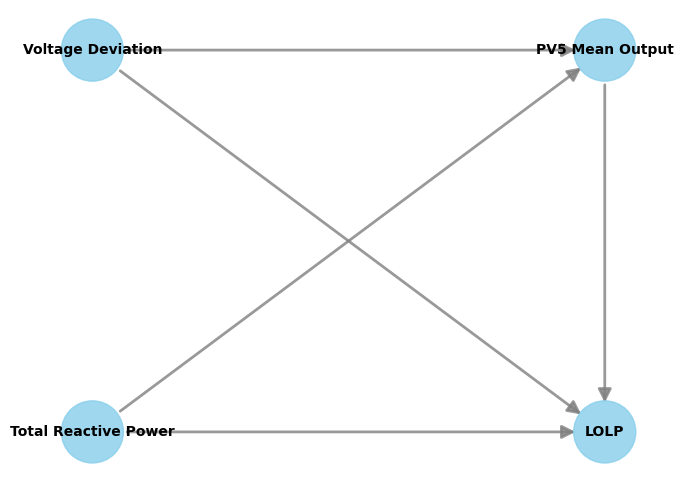

Causal Effect of PV5 Mean Output on LOLP: -0.0024953879345202268


Analyzing causal effect of Total Solar Generation on LOLP:


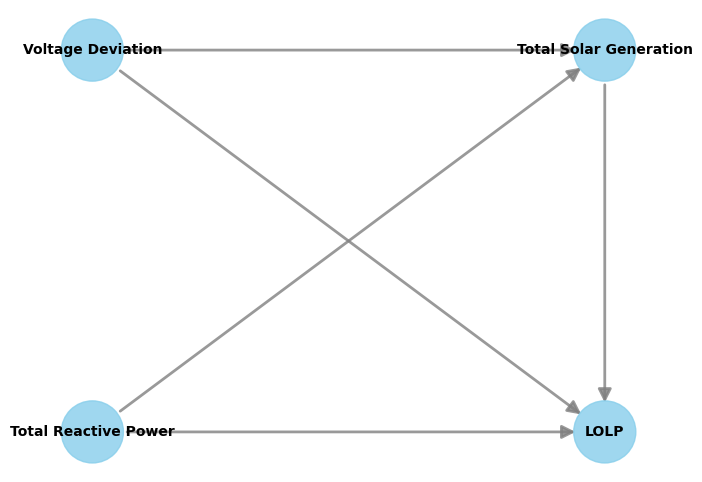

Causal Effect of Total Solar Generation on LOLP: -0.007492839547257213




In [141]:
# Iterate over each PV bus output as the treatment variable
pv_buses = ['PV1 Mean Output', 'PV2 Mean Output', 'PV3 Mean Output', 'PV4 Mean Output', 'PV5 Mean Output','Total Solar Generation']

for pv_bus in pv_buses:
    print(f"Analyzing causal effect of {pv_bus} on LOLP:")
    # Define the causal model
    model = CausalModel(
    data=data,
    treatment=pv_bus,  # Treatments
    outcome='LOLP',  # Reliability indicator
    common_causes=['Voltage Deviation', 'Total Reactive Power']  # Confounders
    )# Visualize the DAG
    model.view_model()

# Identify and estimate the causal effect
    identified_estimand = model.identify_effect()
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"
    )
    
    print(f"Causal Effect of {pv_bus} on LOLP: {causal_estimate.value}")
    print("\n")


In [142]:
import pandapower.networks as pn

# Load the IEEE 30-bus system
net = pn.case30()

# Display parameters of the network
print("Buses:\n", net.bus)
print("Lines:\n", net.line)
print("Loads:\n", net.load)
print("Generators:\n", net.gen)
print("External Grid:\n", net.ext_grid)
print("Shunt Elements:\n", net.shunt)
print("Transformers:\n", net.trafo)

Buses:
    name  vn_kv type zone  in_service  max_vm_pu  min_vm_pu
0     1  135.0    b  1.0        True       1.05       0.95
1     2  135.0    b  1.0        True       1.10       0.95
2     3  135.0    b  1.0        True       1.05       0.95
3     4  135.0    b  1.0        True       1.05       0.95
4     5  135.0    b  1.0        True       1.05       0.95
5     6  135.0    b  1.0        True       1.05       0.95
6     7  135.0    b  1.0        True       1.05       0.95
7     8  135.0    b  1.0        True       1.05       0.95
8     9  135.0    b  1.0        True       1.05       0.95
9    10  135.0    b  3.0        True       1.05       0.95
10   11  135.0    b  1.0        True       1.05       0.95
11   12  135.0    b  2.0        True       1.05       0.95
12   13  135.0    b  2.0        True       1.10       0.95
13   14  135.0    b  2.0        True       1.05       0.95
14   15  135.0    b  2.0        True       1.05       0.95
15   16  135.0    b  2.0        True       1.05 